In [2]:
import tonic
import torch
import numpy as np
import tonic.transforms as transforms

## Read Data and Transforms

In [3]:
n_steps = 16
sensor_size = tonic.datasets.NMNIST.sensor_size
denoise_filter_time = 10000

In [4]:
class MergePolarity:
    def __init__(self):
        pass

    def __call__(Self, x):
        return x[:, 0, :, :] # Take Positive polarity

class PermuteChannels:
    def __call__(self, x):
        # If input is a NumPy array: (C, H, W)
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)  # Convert to tensor
        return x.permute(1, 2, 0)  # (C, H, W) → (H, W, C)

class NormalizeZeroToOne:
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def __call__(self, x):
        x = (x - self.min) / (self.max - self.min)  # [0, 1]
        return x

In [5]:
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=n_steps)
denoise_transform = tonic.transforms.Denoise(filter_time=denoise_filter_time)
merge_polarity_transform = MergePolarity()
permute_channel_transform = PermuteChannels()

In [6]:
transform = transforms.Compose([denoise_transform, frame_transform, merge_polarity_transform, permute_channel_transform])

train_dataset = tonic.datasets.NMNIST(
    save_to="../tutorials/data", train=True, transform=transform
)

test_dataset  = tonic.datasets.NMNIST(
    save_to="../tutorials/data", train=False, transform=transform
)

In [14]:
#Compute global maximum and global minimum
def compute_global_min_max(dataset):
    min_val, max_val = float('inf'), float('-inf')
    for i in range(len(dataset)):
        data, _ = dataset[i]
        data_min, data_max = data.min(), data.max()
        min_val = min(min_val, data_min)
        max_val = max(max_val, data_max)
    return min_val, max_val

global_min, global_max = compute_global_min_max(train_dataset)

global_min_int = int(global_min)
global_max_int = int(global_max)

In [8]:
global_min_int, global_max_int

(0, 13)

In [9]:
normalize_transform = NormalizeZeroToOne(global_min_int, global_max_int)

transform = transforms.Compose([
denoise_transform, frame_transform, merge_polarity_transform, permute_channel_transform, normalize_transform
])

In [10]:
train_dataset = tonic.datasets.NMNIST(
    save_to="/data/sweta_das/CV_data/nmnist", train=True, transform=transform
)

test_dataset  = tonic.datasets.NMNIST(
    save_to="/data/sweta_das/CV_data/nmnist", train=False, transform=transform
)

In [11]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([34, 34, 16]), 0)

In [12]:
 test_dataset[0][0].shape, test_dataset[0][1]

(torch.Size([34, 34, 16]), 0)

## VISUALIZATION

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_frames_without_polarity_permuted(data_tensor):
    """
    Plots individual image frames from a 3D tensor where the last dimension
    represents timesteps.

    Args:
        data_tensor (torch.Tensor or np.ndarray): A tensor/array of shape
                                                  [x_dim, y_dim, num_timesteps],
                                                  e.g., [34, 34, 16].
    """
    # Ensure the input is a NumPy array for Matplotlib
    if isinstance(data_tensor, torch.Tensor):
        # Move to CPU if it's on GPU, then convert to NumPy
        data_np = data_tensor.cpu().numpy()
    elif isinstance(data_tensor, np.ndarray):
        data_np = data_tensor
    else:
        raise TypeError("Input data_tensor must be a torch.Tensor or numpy.ndarray")

    # The number of timesteps is the size of the last dimension
    num_timesteps = data_np.shape[2]

    # Determine optimal subplot grid (e.g., 4 columns)
    n_cols = 16
    n_rows = 1

    # Create the figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    # Flatten the axes array for easier iteration, handling cases with 1 row/col
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes]) # Ensure it's an iterable array even for a single plot
    else:
        axes = axes.flatten()

    for i in range(num_timesteps):
        ax = axes[i]
        # Extract the 2D image for the current timestep (slice along the last dimension)
        frame = data_np[:, :, i]

        ax.imshow(frame) # Use 'gray' colormap for single-channel data
        ax.set_title(f'T{i+1}', fontsize=24) # Add title for each frame
        ax.axis("off") # Hide axis ticks and labels

    # Hide any unused subplots if the number of timesteps doesn't perfectly fill the grid
    for i in range(num_timesteps, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.suptitle('Image at Each Timestep', y=1.3, fontsize=28) # Add a main title
    plt.show() # Display the plot

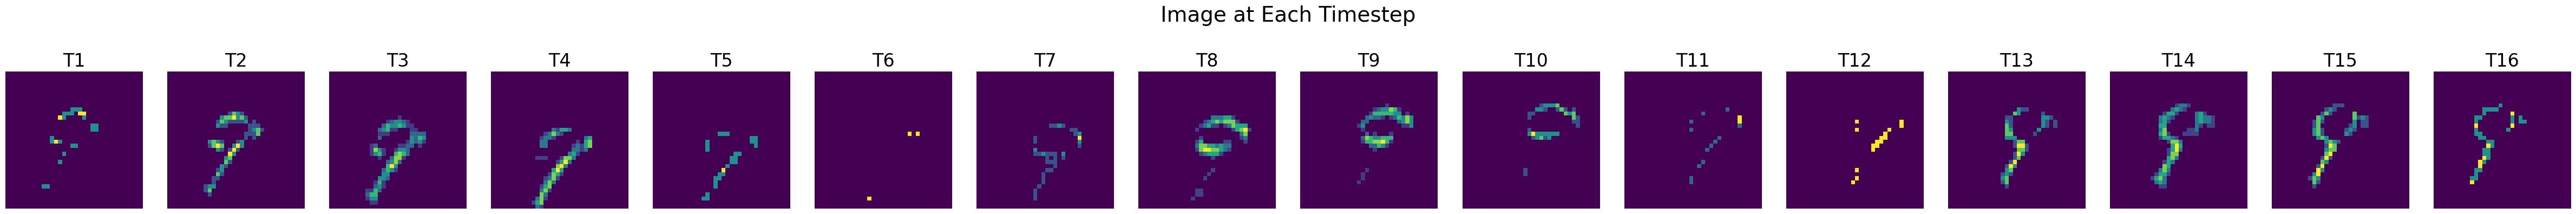

In [14]:
plot_frames_without_polarity_permuted(train_dataset[55143][0])

In [15]:
import snntorch.spikeplot as splt
from IPython.display import HTML

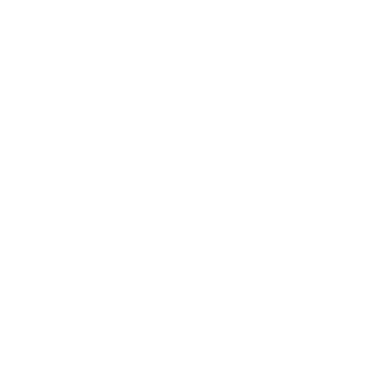

In [16]:
fig, ax = plt.subplots()
anim = splt.animator(train_dataset[55143][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

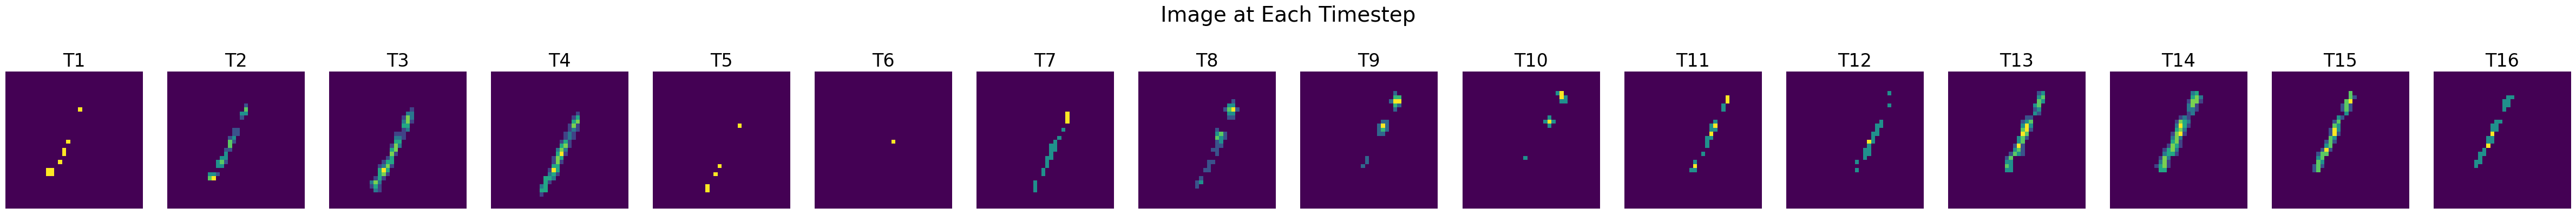

In [17]:
plot_frames_without_polarity_permuted(train_dataset[12345][0])

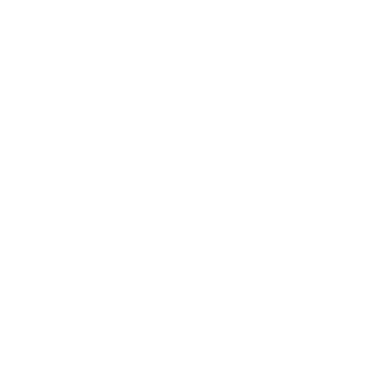

In [18]:
fig, ax = plt.subplots()
anim = splt.animator(train_dataset[12345][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

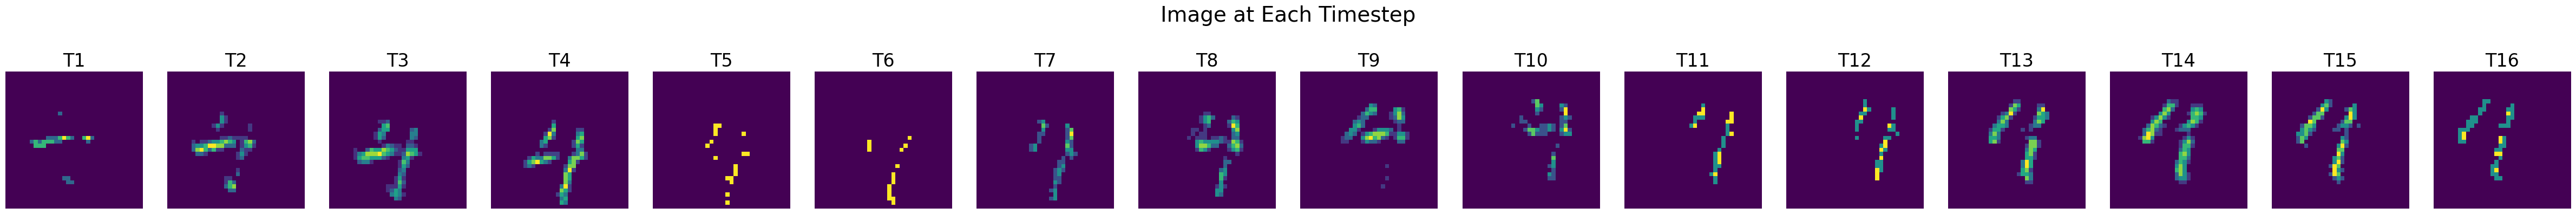

In [19]:
plot_frames_without_polarity_permuted(train_dataset[25143][0])

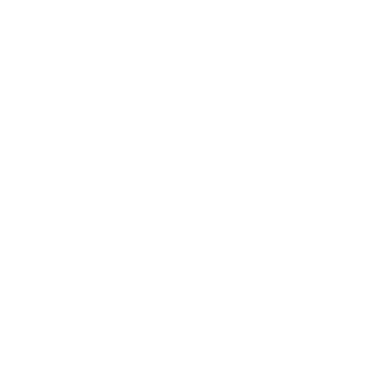

In [20]:
fig, ax = plt.subplots()
anim = splt.animator(train_dataset[25143][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

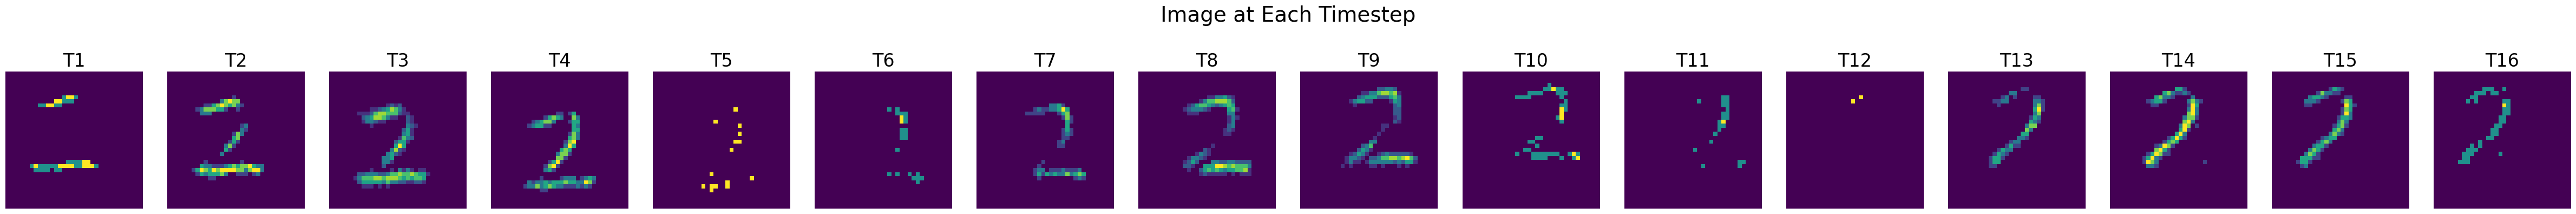

In [21]:
plot_frames_without_polarity_permuted(train_dataset[15143][0])

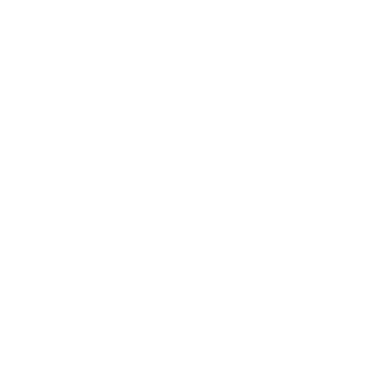

In [22]:
fig, ax = plt.subplots()
anim = splt.animator(train_dataset[15143][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h2>Data Loader</h2>

In [23]:
from torch.utils.data import DataLoader

batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False, num_workers=0, pin_memory=True)


In [24]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([32, 34, 34, 16])
Train batch - labels shape: torch.Size([32])


In [25]:
data_iter = iter(testloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([64, 34, 34, 16])
Train batch - labels shape: torch.Size([64])


In [26]:
print("Number of training batches:", len(trainloader))
print("Number of test batches:", len(testloader))

print("Total training samples:", len(train_dataset))
print("Total test samples:", len(test_dataset))

Number of training batches: 1875
Number of test batches: 157
Total training samples: 60000
Total test samples: 10000


<h2>MODEL</h2>

<h3> LAYERS </h3>

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

<h4> Hyperparameters SNN </h4>

In [28]:
dt = 5
a = 0.25
aa = 0.5  
Vth = 0.2
tau = 0.35

<h4> LIF Layers </h4>

In [29]:
class SpikeAct(torch.autograd.Function):
    """ 
        Implementation of the spiking activation function with an approximation of gradient.
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # if input = u > Vth then output = 1
        output = torch.gt(input, Vth) 
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors 
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(input) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu

class LIFSpike(nn.Module):
    """
        Generates spikes based on LIF module. It can be considered as an activation function and is used similar to ReLU. The input tensor needs to have an additional time dimension, which in this case is on the last dimension of the data.
    """
    def __init__(self):
        super(LIFSpike, self).__init__()

    def forward(self, x):
        nsteps = x.shape[-1]
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        out = torch.zeros(x.shape, device=x.device)
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step])
        return out
    
    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, tau=tau):
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n
        o_t1_n1 = SpikeAct.apply(u_t1_n1)
        return u_t1_n1, o_t1_n1

class MySpikeAct(SpikeAct):
    """
        Implementation of the spiking activation function with an approximation of gradient.
    """
    @staticmethod
    def forward(ctx, input):
        data, Vth = input
        ctx.save_for_backward(input)
        # if input = u > Vth then output = 1
        output = torch.gt(data, Vth)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        data, Vth, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(data) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu


class MyLIFSpike(LIFSpike):
    """
        Generates spikes based on LIF module. It can be considered as an activation function and is used similar to ReLU. The input tensor needs to have an additional time dimension, which in this case is on the last dimension of the data.
    """

    def __init__(self):
        super(MyLIFSpike, self).__init__()

    def forward(self, input):
        x, Vth = input
        nsteps = x.shape[-1]
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        out = torch.zeros(x.shape, device=x.device)
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step], Vth)
        return out

    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, Vth, tau=tau):
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n
        o_t1_n1 = MySpikeAct.apply([u_t1_n1, Vth])
        return u_t1_n1, o_t1_n1


<h4> Linear Layer </h4>

In [30]:
class tdLinear(nn.Linear):
    def __init__(self, 
                in_features,
                out_features,
                bias=True,
                bn=None,
                spike=None):
        assert type(in_features) == int, 'inFeatures should not be more than 1 dimesnion. It was: {}'.format(in_features.shape)
        assert type(out_features) == int, 'outFeatures should not be more than 1 dimesnion. It was: {}'.format(out_features.shape)

        super(tdLinear, self).__init__(in_features, out_features, bias=bias)

        self.bn = bn
        self.spike = spike
        

    def forward(self, x):
        """
        x : (N,C,T)
        """        
        x = x.transpose(1, 2) # (N, T, C)
        y = F.linear(x, self.weight, self.bias)
        y = y.transpose(1, 2)# (N, C, T)
        
        if self.bn is not None:
            y = y[:,:,None,None,:]
            y = self.bn(y)
            y = y[:,:,0,0,:]
        if self.spike is not None:
            y = self.spike(y)
        return y


<h4> Convolution Layer </h4>

In [31]:
class tdConv(nn.Conv3d):
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None,
                is_first_conv=False):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))

        super(tdConv, self).__init__(in_channels, out_channels, kernel, stride, padding, dilation, groups,
                                        bias=bias)
        self.bn = bn
        self.spike = spike
        self.is_first_conv = is_first_conv

    def forward(self, x):
        x = F.conv3d(x, self.weight, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)
        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x

<h4> ConvTranspose Layer</h4>

In [32]:
class tdConvTranspose(nn.ConvTranspose3d):
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                output_padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))


        # output padding
        if type(output_padding) == int:
            output_padding = (output_padding, output_padding, 0)
        elif len(output_padding) == 2:
            output_padding = (output_padding[0], output_padding[1], 0)
        elif len(output_padding) == 3:
            output_padding = output_padding
        else:
            raise Exception('output_padding can be either int or tuple of size 2 or tuple of size 3. It was: {}'.format(padding.shape))

        super().__init__(in_channels, out_channels, kernel, stride, padding, output_padding, groups,
                                        bias=bias, dilation=dilation)

        self.bn = bn
        self.spike = spike

    def forward(self, x):
        x = F.conv_transpose3d(x, self.weight, self.bias,
                        self.stride, self.padding, 
                        self.output_padding, self.groups, self.dilation)

        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x

<h4> Batch Norm</h4>

In [33]:
class tdBatchNorm(nn.BatchNorm2d):
    """
        Implementation of tdBN. Link to related paper: https://arxiv.org/pdf/2011.05280. In short it is averaged over the time domain as well when doing BN.
    Args:
        num_features (int): same with nn.BatchNorm2d
        eps (float): same with nn.BatchNorm2d
        momentum (float): same with nn.BatchNorm2d
        alpha (float): an addtional parameter which may change in resblock.
        affine (bool): same with nn.BatchNorm2d
        track_running_stats (bool): same with nn.BatchNorm2d
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.2, alpha=0.9, affine=True, track_running_stats=True):
        super(tdBatchNorm, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, input):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3, 4])
            # use biased var in train
            var = input.var([0, 2, 3, 4], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = self.alpha * Vth * (input - mean[None, :, None, None, None]) / (torch.sqrt(var[None, :, None, None, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None, None, None] + self.bias[None, :, None, None, None]
        
        return input


<h4>MMD Loss</h4>

In [34]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_type='linear', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

In [35]:
class SampledSpikeAct(torch.autograd.Function):
    """
        Implementation of the spiking activation function with an approximation of gradient.
    """

    @staticmethod
    def forward(ctx, input):
        random_sign = torch.rand_like(input, dtype=input.dtype).to(input.device)
        ctx.save_for_backward(input, random_sign)
        # if input = u > Vth then output = 1
        output = torch.gt(input, random_sign)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, random_sign = ctx.saved_tensors
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(input - random_sign) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu

<h4> VAE</h4>

In [36]:
class VAE(nn.Module):
    def __init__(self, device='cuda:0', distance_lambda=0.001, mmd_type='rbf', in_channels=1, latent_dim=64, n_steps=16):
        super().__init__()

        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.n_steps = n_steps

        self.device = device
        self.distance_lambda = distance_lambda
        self.mmd_type = mmd_type

        hidden_dims = [32, 64, 128, 256, 512]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        modules = []
        is_first_conv = True
        for h_dim in hidden_dims:
            modules.append(
                tdConv(in_channels,
                       out_channels=h_dim,
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       bias=True,
                       bn=tdBatchNorm(h_dim),
                       spike=LIFSpike(),
                       is_first_conv=is_first_conv)
            )
            in_channels = h_dim
            is_first_conv = False

        self.encoder = nn.Sequential(*modules)
        self.before_latent_layer = tdLinear(hidden_dims[-1] * 4,
                                            latent_dim,
                                            bias=True,
                                            bn=tdBatchNorm(latent_dim),
                                            spike=LIFSpike())

        # Build Decoder
        modules = []

        self.decoder_input = tdLinear(latent_dim,
                                      hidden_dims[-1] * 4,
                                      bias=True,
                                      bn=tdBatchNorm(hidden_dims[-1] * 4),
                                      spike=LIFSpike())

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                tdConvTranspose(hidden_dims[i],
                                hidden_dims[i + 1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=0,
                                bias=True,
                                bn=tdBatchNorm(hidden_dims[i + 1]),
                                spike=LIFSpike())
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            tdConvTranspose(hidden_dims[-1],
                            out_channels=1,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=(1,1,0),
                            bias=True,
                            bn=None,
                            spike=None)
        )

        self.p = 0

        self.sample_layer = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.Sigmoid()
        )

        self.mmd_loss = MMD_loss(kernel_type=self.mmd_type)

    def forward(self, x, scheduled=False):
        sampled_z_q, r_q, r_p = self.encode(x, scheduled)
        x_recon = self.decode(sampled_z_q)
        return x_recon, r_q, r_p, sampled_z_q

    def encode(self, x, scheduled=False, return_firing_rate=False):
        x = self.encoder(x)  # (N,C,H,W,T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N,C*H*W,T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        return sampled_z_q, r_q, r_p

    def decode(self, z):
        result = self.decoder_input(z)  # (N,C*H*W,T)
        result = result.view(result.shape[0], self.hidden_dims[-1], 2, 2, self.n_steps)  # (N,C,H,W,T)
        result = self.decoder(result)  # (N,C,H,W,T)
        result = self.final_layer(result)  # (N,C,H,W,T)
        out = result
        return out

    def sample(self, batch_size=32):
        sampled_z_p, _, _ = self.gaussian_sample(batch_size=batch_size)
        sampled_x = self.decode(sampled_z_p)
        return sampled_x, sampled_z_p

    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        if latent_x is not None:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None

    def loss_function_mmd(self, input_img, recons_img, r_q, r_p):
        """
        r_q is q(z|x): (N,latent_dim)
        r_p is p(z): (N,latent_dim)
        """
        recons_loss = F.mse_loss(recons_img, input_img)
        mmd_loss = self.mmd_loss(r_q, r_p)
        loss = recons_loss + self.distance_lambda * mmd_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss, 'Distance_Loss': mmd_loss}

    def weight_clipper(self):
        with torch.no_grad():
            for p in self.parameters():
                p.data.clamp_(-4, 4)

    def update_p(self, epoch, max_epoch):
        init_p = 0.1
        last_p = 0.3
        self.p = (last_p - init_p) * epoch / max_epoch + init_p


<h3>UTIL</h3>

In [40]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib import gridspec

def plot_two_tensors_16_frames_each(tensor1, tensor2, label, epoch, save_path="two_tensors_plot.png"):
    """
    Plots two tensors side by side in rows: 
    - First tensor's 16 timesteps in the first row
    - Second tensor's 16 timesteps in the second row
    Saves the figure to a file.

    Args:
        tensor1, tensor2 (torch.Tensor or np.ndarray): Shape [x_dim, y_dim, 16].
        save_path (str): Path to save the resulting figure.
    """
    # Convert tensors to NumPy arrays
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        elif isinstance(t, np.ndarray):
            return t
        else:
            raise TypeError("Inputs must be torch.Tensor or numpy.ndarray")

    data1 = to_numpy(tensor1)
    data2 = to_numpy(tensor2)

    # Check shape consistency
    if data1.shape[2] != 16 or data2.shape[2] != 16:
        raise ValueError("Both tensors must have exactly 16 timesteps in the last dimension.")

    row_gap= .5
    n_cols = 16
    fig = plt.figure(figsize=(n_cols * 2, 2 * 2 + row_gap))
    gs = gridspec.GridSpec(2, n_cols, height_ratios=[1, 1], hspace=row_gap / 2)

    # First row
    for i in range(16):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(data1[:, :, i])
        ax.set_title(f'T{i+1}', fontsize=10)
        ax.axis("off")

    fig.text(0.5, 0.94, "Epoch: " + str(epoch) + " and Label " + str(label) + ": Input Frame", ha='center', va='center', fontsize=18)

    # Second row
    for i in range(16):
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(data2[:, :, i])
        ax.set_title(f'T{i+1}', fontsize=10)
        ax.axis("off")

    fig.text(0.5, 0.51, "Epoch: " + str(epoch) + " and Label " + str(label) + ": Reconstructed Frame", ha='center', va='center', fontsize=18)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


<H2>Model Training and Testing</H2>

In [43]:
import os
import os.path
import json
import random
import numpy as np
import logging
import argparse
import torchvision
from collections import defaultdict

<h4> Init Functions </h4>

In [44]:
def init_stats_dict():
    return {
        "per_epoch": defaultdict(list),
        "histogram_cache": [],   
        "per_epoch_test": defaultdict(list),
        "test_histogram_cache": []  
    }

def save_epoch_images(real_img, x_recon, label, epoch, checkpoint_dir):
    """
    Saves per-epoch input and reconstruction image grids as PNGs.
    """
    img_dir = os.path.join(checkpoint_dir, "imgs")
    os.makedirs(img_dir, exist_ok=True)

    plot_two_tensors_16_frames_each(real_img, x_recon, label, epoch, save_path=f"{checkpoint_dir}/imgs/epoch_{epoch}_img.png")

def save_mean_z_heatmap(mean_sampled_z_q, epoch, checkpoint_dir):
    """
    Optional: visualizes (C,T) mean_sampled_z_q as a heatmap.
    """
    img_dir = os.path.join(checkpoint_dir, "hist")
    os.makedirs(img_dir, exist_ok=True)

    arr = mean_sampled_z_q.detach().cpu().numpy()
    plt.figure()
    plt.imshow(arr, aspect="auto")
    plt.colorbar()
    plt.title(f"Mean sampled_z_q (epoch {epoch})")
    out_path = os.path.join(img_dir, f"epoch{epoch}_mean_sampled_z_q.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()

def accumulate_running_mean(prev_mean, new_batch_tensor, batch_idx):
    new_mean = new_batch_tensor.mean(0).detach().cpu()
    if batch_idx == 0:
        return new_mean
    return (new_mean + batch_idx * prev_mean) / (batch_idx + 1)

<h3> Train and Test Functions</h3>

In [45]:


@torch.no_grad()
def test_one_epoch(network, testloader, epoch, max_epoch, stats_dict, checkpoint_dir):
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    mean_r_q = 0
    mean_r_p = 0
    mean_sampled_z_q = 0

    network.eval()

    for batch_idx, (real_img, labels) in enumerate(testloader):

        real_img = real_img.to('cuda:0', non_blocking=True)
        labels   = labels.to('cuda:0', non_blocking=True)

        spike_input = real_img.unsqueeze(1)
        x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=False)

        losses = network.loss_function_mmd(spike_input, x_recon, r_q, r_p)

        # meters
        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

        # running means
        mean_r_q = accumulate_running_mean(mean_r_q, r_q, batch_idx)
        mean_r_p = accumulate_running_mean(mean_r_p, r_p, batch_idx)
        mean_sampled_z_q = accumulate_running_mean(mean_sampled_z_q, sampled_z_q, batch_idx)

        # histogram cache
        per_batch_mean = sampled_z_q.mean(0)        # (latent_dim, T)
        distribution_vec = per_batch_mean.sum(-1)   # (latent_dim,)
        stats_dict["test_histogram_cache"].append(distribution_vec.detach().cpu())

        # print(
        #     f'Test[{epoch}/{max_epoch}] [{batch_idx}/{len(testloader)}] '
        #     f'Loss: {loss_meter.avg:.5f}, RECONS: {recons_meter.avg:.5f}, DISTANCE: {dist_meter.avg:.5f}'
        # )

        hist_epoch_dir = os.path.join(checkpoint_dir, "hist_test")
        os.makedirs(hist_epoch_dir, exist_ok=True)
        # Save sample images at last batch
        if batch_idx == 0:
            save_epoch_images(spike_input[0][0], x_recon[0][0], str(labels[0]), epoch, checkpoint_dir)

            # mean_z heatmap
            arr = mean_sampled_z_q.detach().cpu().numpy()
            plt.figure()
            plt.imshow(arr, aspect="auto")
            plt.colorbar()
            plt.title(f"Mean sampled_z_q (Test epoch {epoch})")
            plt.savefig(f"{checkpoint_dir}/hist_test/epoch{epoch}_mean_sampled_z_q.png", bbox_inches="tight")
            plt.close()

    # per-epoch scalars
    print(f"Test [{epoch}] Loss: {loss_meter.avg:.5f} ReconsLoss: {recons_meter.avg:.5f} DISTANCE: {dist_meter.avg:.5f}")
    stats_dict["per_epoch_test"]["loss"].append(loss_meter.avg)
    stats_dict["per_epoch_test"]["recons_loss"].append(recons_meter.avg)
    stats_dict["per_epoch_test"]["distance"].append(dist_meter.avg)
    stats_dict["per_epoch_test"]["mean_r_q"].append(mean_r_q.mean().item())
    stats_dict["per_epoch_test"]["mean_r_p"].append(mean_r_p.mean().item())

    return loss_meter.avg

# ------------------- full test loop -------------------

def test_model(network, testloader, num_epochs=1, checkpoint_dir="vae_v6/checkpoint/nmnist/test"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Extend stats dict to hold test info
    if "per_epoch_test" not in stats_dict_global:
        stats_dict_global["per_epoch_test"] = defaultdict(list)
    if "test_histogram_cache" not in stats_dict_global:
        stats_dict_global["test_histogram_cache"] = []

    for epoch in range(1, num_epochs + 1):
        _ = test_one_epoch(
            network=network,
            testloader=testloader,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict_global,
            checkpoint_dir=checkpoint_dir
        )

    # Final histogram for test set
    hist_dir = os.path.join(checkpoint_dir, "hist_test_final")
    os.makedirs(hist_dir, exist_ok=True)
    
    if len(stats_dict_global["test_histogram_cache"]) > 0:
        all_vals = torch.cat(stats_dict_global["test_histogram_cache"], dim=0)
        vmin, vmax = float(all_vals.min()), float(all_vals.max())
        if vmin == vmax:
            vmin, vmax = vmin - 0.5, vmax + 0.5
        bins = 50
        counts = torch.histc(all_vals, bins=bins, min=vmin, max=vmax)
        edges  = torch.linspace(vmin, vmax, steps=bins + 1)

        np.savez(os.path.join(hist_dir, "final_histogram_test.npz"),
                 counts=counts.cpu().numpy(), bin_edges=edges.cpu().numpy())

        plt.figure()
        plt.bar(0.5*(edges[:-1].numpy()+edges[1:].numpy()), counts.numpy(),
                width=(edges[1:].numpy()-edges[:-1].numpy()))
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.title("Final Test Distribution of mean(sampled_z_q, batch).sum(time)")
        plt.tight_layout()
        plt.savefig(os.path.join(hist_dir, "final_histogram_test.png"), bbox_inches="tight")
        plt.close()

        stats_dict_global["final_test_histogram"] = {"counts": counts, "bin_edges": edges}
    else:
        stats_dict_global["final_test_histogram"] = {"counts": torch.tensor([]), "bin_edges": torch.tensor([])}

    return stats_dict_global


In [46]:
def train_one_epoch(network, trainloader, opti, epoch, max_epoch, stats_dict, checkpoint_dir):
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    mean_r_q = 0
    mean_r_p = 0
    mean_sampled_z_q = 0

    network.train()

    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to('cuda:0', non_blocking=True)
        labels   = labels.to('cuda:0', non_blocking=True)

        spike_input = real_img.unsqueeze(1)
        x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=True)

        losses = network.loss_function_mmd(spike_input, x_recon, r_q, r_p)
        losses['loss'].backward()
        opti.step()

        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

        mean_r_q = accumulate_running_mean(mean_r_q, r_q, batch_idx)
        mean_r_p = accumulate_running_mean(mean_r_p, r_p, batch_idx)
        mean_sampled_z_q = accumulate_running_mean(mean_sampled_z_q, sampled_z_q, batch_idx)

        # cache distribution vector for final histogram (per original logic)
        with torch.no_grad():
            per_batch_mean = sampled_z_q.mean(0)       # (latent_dim, T)
            distribution_vec = per_batch_mean.sum(-1)  # (latent_dim,)
            stats_dict["histogram_cache"].append(distribution_vec.detach().cpu())

        # print(
        #     f'Train[{epoch}/{max_epoch}] [{batch_idx}/{len(trainloader)}] '
        #     f'Loss: {loss_meter.avg:.5f}, RECONS: {recons_meter.avg:.5f}, DISTANCE: {dist_meter.avg:.5f}'
        # )

        # Save epoch-end images
        if batch_idx == len(trainloader) - 1:
            save_epoch_images(spike_input[0][0], x_recon[0][0], str(labels[0]), epoch, checkpoint_dir)

    # per-epoch scalar stats
    print(f"Train [{epoch}] Loss: {loss_meter.avg:.5f} ReconsLoss: {recons_meter.avg:.5f} DISTANCE: {dist_meter.avg:.5f}")
    stats_dict["per_epoch"]["loss"].append(loss_meter.avg)
    stats_dict["per_epoch"]["recons_loss"].append(recons_meter.avg)
    stats_dict["per_epoch"]["distance"].append(dist_meter.avg)
    stats_dict["per_epoch"]["mean_r_q"].append(mean_r_q.mean().item())
    stats_dict["per_epoch"]["mean_r_p"].append(mean_r_p.mean().item())

    # keep and optionally plot the mean (C,T) array
    save_mean_z_heatmap(mean_sampled_z_q, epoch, checkpoint_dir)

    return loss_meter.avg

# ------------- full training -------------

def train_model(network, trainloader, testloader, opti, num_epochs=15, checkpoint_dir="vae_v6/checkpoint/nmnist/train"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    stats_dict = init_stats_dict()

    for epoch in range(1, num_epochs + 1):
        _ = train_one_epoch(
            network=network,
            trainloader=trainloader,
            opti=opti,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict,
            checkpoint_dir=checkpoint_dir
        )
        _ = test_one_epoch(
            network=network,
            testloader=testloader,
            epoch=epoch,
            max_epoch=num_epochs,
            stats_dict=stats_dict,
            checkpoint_dir="vae_v6/checkpoint/nmnist/test"
        )

    # ---- final histogram after ALL epochs ----
    hist_dir = os.path.join(checkpoint_dir, "final_hist")
    os.makedirs(hist_dir, exist_ok=True)

    if len(stats_dict["histogram_cache"]) > 0:
        all_vals = torch.cat(stats_dict["histogram_cache"], dim=0)  # (num_batches_total*latent_dim,)
        vmin, vmax = float(all_vals.min()), float(all_vals.max())
        if vmin == vmax:  # degenerate case
            vmin, vmax = vmin - 0.5, vmax + 0.5
        bins = 50
        counts = torch.histc(all_vals, bins=bins, min=vmin, max=vmax)   # torch.Tensor
        edges  = torch.linspace(vmin, vmax, steps=bins + 1)             # torch.Tensor

        # save raw arrays
        np.savez(os.path.join(hist_dir, "final_histogram.npz"),
                 counts=counts.cpu().numpy(), bin_edges=edges.cpu().numpy())

        # save a PNG plot
        plt.figure()
        plt.bar(0.5*(edges[:-1].numpy()+edges[1:].numpy()), counts.numpy(),
                width=(edges[1:].numpy()-edges[:-1].numpy()))
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.title("Final Distribution of mean(sampled_z_q, batch).sum(time)")
        plt.tight_layout()
        plt.savefig(os.path.join(hist_dir, "final_histogram.png"), bbox_inches="tight")
        plt.close()

        # also store in the dict in case you need it in-session
        stats_dict["final_histogram"] = {"counts": counts, "bin_edges": edges}
    else:
        stats_dict["final_histogram"] = {"counts": torch.tensor([]), "bin_edges": torch.tensor([])}
    return stats_dict

<h4> Model Definition and Run</h4>

In [47]:
lr = 0.0003
sample_layer_lr_times = 10
distance_lambda = 0.001
loss_func = 'mmd'
mmd_type = 'rbf'
latent_dim = 64

In [48]:
net = VAE()
net = net.to('cuda:0')

In [49]:
params = list(net.named_parameters())
param_group = [
        {'params': [p for n, p in params if 'sample_layer' in n], 'weight_decay': 0.001, 'lr': lr * sample_layer_lr_times},
        {'params': [p for n, p in params if 'sample_layer' not in n], 'weight_decay': 0.001, 'lr': lr},
]

optimizer = torch.optim.AdamW(param_group, lr=lr, betas=(0.9, 0.999), weight_decay=0.001)

In [50]:
stats_dict_global = train_model(net, trainloader, testloader, optimizer, num_epochs=15, checkpoint_dir="vae_v6/checkpoint/nmnist/train")   

update p
Train [1] Loss: 0.03701 ReconsLoss: 0.03647 DISTANCE: 0.54005
Test [1] Loss: 0.00354 ReconsLoss: 0.00286 DISTANCE: 0.68129
Train [2] Loss: 0.00215 ReconsLoss: 0.00184 DISTANCE: 0.31046
Test [2] Loss: 0.00262 ReconsLoss: 0.00170 DISTANCE: 0.92735
Train [3] Loss: 0.00197 ReconsLoss: 0.00168 DISTANCE: 0.29065
Test [3] Loss: 0.00245 ReconsLoss: 0.00168 DISTANCE: 0.76960
Train [4] Loss: 0.00185 ReconsLoss: 0.00166 DISTANCE: 0.18439
Test [4] Loss: 0.00224 ReconsLoss: 0.00168 DISTANCE: 0.55112
Train [5] Loss: 0.00185 ReconsLoss: 0.00166 DISTANCE: 0.18834
Test [5] Loss: 0.00245 ReconsLoss: 0.00167 DISTANCE: 0.78858
Train [6] Loss: 0.00180 ReconsLoss: 0.00164 DISTANCE: 0.15960
Test [6] Loss: 0.00230 ReconsLoss: 0.00165 DISTANCE: 0.65188
Train [7] Loss: 0.00179 ReconsLoss: 0.00163 DISTANCE: 0.16056
Test [7] Loss: 0.00241 ReconsLoss: 0.00163 DISTANCE: 0.78026
Train [8] Loss: 0.00179 ReconsLoss: 0.00161 DISTANCE: 0.17908
Test [8] Loss: 0.00245 ReconsLoss: 0.00162 DISTANCE: 0.83364
Train [

<h3> Plots and Visualization</h3>

In [62]:
import os
import math
import matplotlib.pyplot as plt

def plot_train_test_curves(stats_dict, out_dir=None, show=True, prefix="", eps=1e-6):
    """
    Plots:
      1) Convergence (Train vs Test): overall, reconstruction, MMD  [log scale]
      2) r_q and r_p (Train/Test)                                   [symlog]
    Looks for train under 'per_epoch' and test under 'per_epoch_test'.
    Saves PNGs if out_dir is provided.
    """

    def _get_block(stats, key):
        return stats.get(key, {}) if isinstance(stats.get(key, {}), dict) else {}

    def _series(block, name):
        v = block.get(name, [])
        return list(v) if isinstance(v, (list, tuple)) else (list(v) if v is not None else [])

    def _epoch_axis(n): return list(range(1, n + 1))

    def _logsafe(y):
        # clamp to eps and drop NaNs/None for log plots
        out = []
        for val in y:
            if val is None: 
                continue
            f = float(val)
            if math.isnan(f) or math.isinf(f):
                continue
            out.append(max(eps, f))
        return out

    train_block = _get_block(stats_dict, "per_epoch")
    test_block  = _get_block(stats_dict, "per_epoch_test")

    # --- train series ---
    tr_loss  = _series(train_block, "loss")
    tr_rec   = _series(train_block, "recons_loss")
    tr_mmd   = _series(train_block, "distance")
    tr_rq    = _series(train_block, "mean_r_q")
    tr_rp    = _series(train_block, "mean_r_p")

    # --- test series ---
    te_loss  = _series(test_block, "loss")
    te_rec   = _series(test_block, "recons_loss")
    te_mmd   = _series(test_block, "distance")
    te_rq    = _series(test_block, "mean_r_q")
    te_rp    = _series(test_block, "mean_r_p")

    # mark every Nth point for readability
    def _markevery(n): return max(1, n // 20)

    def _plot_two_log(y_train, y_test, title, ylabel, filename):
        yt = _logsafe(y_train)
        yv = _logsafe(y_test)
        fig, ax = plt.subplots(figsize=(8, 5))
        if yt: ax.plot(_epoch_axis(len(yt)), yt, marker="o", ms=5, lw=1.8,
                       markevery=_markevery(len(yt)), label="Train")
        if yv: ax.plot(_epoch_axis(len(yv)), yv, marker="s", ms=5, lw=1.8,
                       markevery=_markevery(len(yv)), linestyle="--", label="Test")
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, which="both", alpha=0.25)
        ax.legend(frameon=False)
        fig.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f"{prefix}{filename}.png"),
                        bbox_inches="tight", dpi=160)
        if show: plt.show()
        else: plt.close(fig)

    def _plot_rq_rp(tr_rq, tr_rp, te_rq, te_rp, filename="r_q_r_p_symlog"):
        fig, ax = plt.subplots(figsize=(8, 5))
        if tr_rq: ax.plot(_epoch_axis(len(tr_rq)), tr_rq, marker="o", ms=5, lw=1.8,
                          markevery=_markevery(len(tr_rq)), label="Train r_q")
        if tr_rp: ax.plot(_epoch_axis(len(tr_rp)), tr_rp, marker="^", ms=5, lw=1.8,
                          markevery=_markevery(len(tr_rp)), label="Train r_p")
        if te_rq: ax.plot(_epoch_axis(len(te_rq)), te_rq, marker="s", ms=5, lw=1.8,
                          markevery=_markevery(len(te_rq)), linestyle="--", label="Test r_q")
        if te_rp: ax.plot(_epoch_axis(len(te_rp)), te_rp, marker="v", ms=5, lw=1.8,
                          markevery=_markevery(len(te_rp)), linestyle="--", label="Test r_p")
        # symlog handles zeros/negatives; adjust linthresh if your values are tiny
        ax.set_yscale("symlog", linthresh=1e-6)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Mean value")
        ax.set_title("r_q and r_p (Train/Test)")
        ax.grid(True, which="both", alpha=0.25)
        ax.legend(frameon=False)
        fig.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f"{prefix}{filename}.png"),
                        bbox_inches="tight", dpi=160)
        if show: plt.show()
        else: plt.close(fig)

    # 1) Convergence: overall, recon, MMD (log scale)
    _plot_two_log(tr_loss, te_loss, "Overall Loss (log scale)", "Loss", "loss_overall_log")
    _plot_two_log(tr_rec,  te_rec,  "Reconstruction Loss (log scale)", "Loss", "loss_reconstruction_log")
    _plot_two_log(tr_mmd,  te_mmd,  "MMD / Distance Loss (log scale)", "Loss", "loss_mmd_log")

    # 2) r_q and r_p (symlog)
    _plot_rq_rp(tr_rq, tr_rp, te_rq, te_rp)


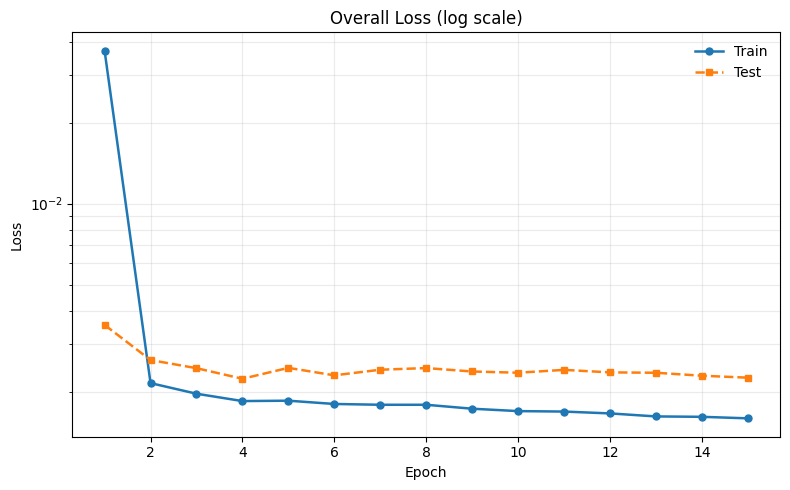

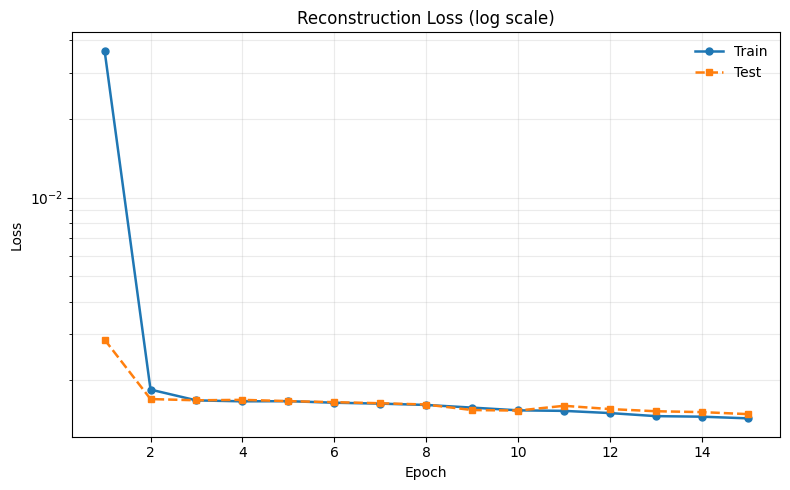

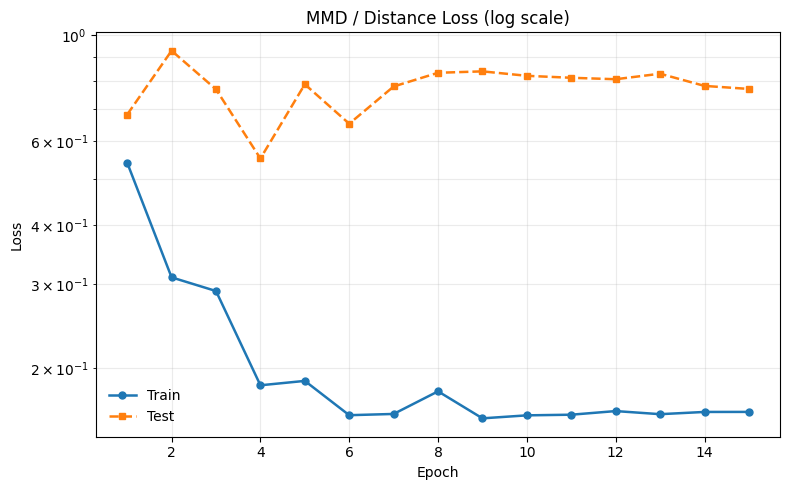

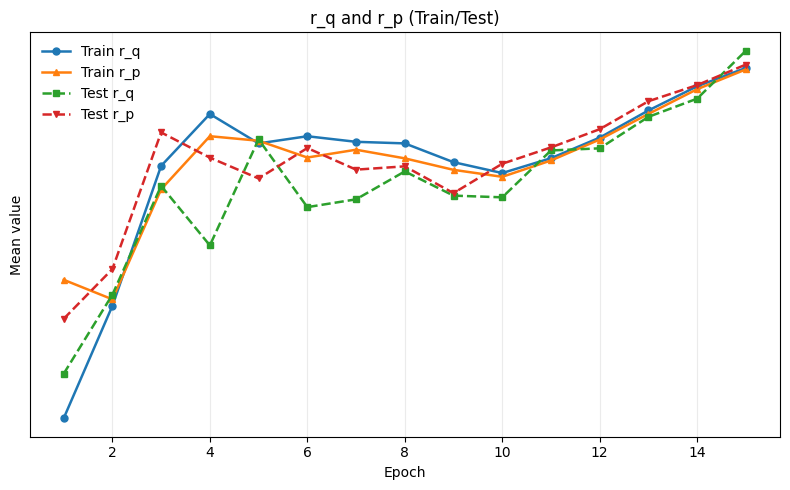

In [64]:
plot_train_test_curves(stats_dict_global, out_dir="vae_v6/checkpoint/nmnist/plots", show=True)


------------------------------------Label 0--------------------------------------------
------Original Events------


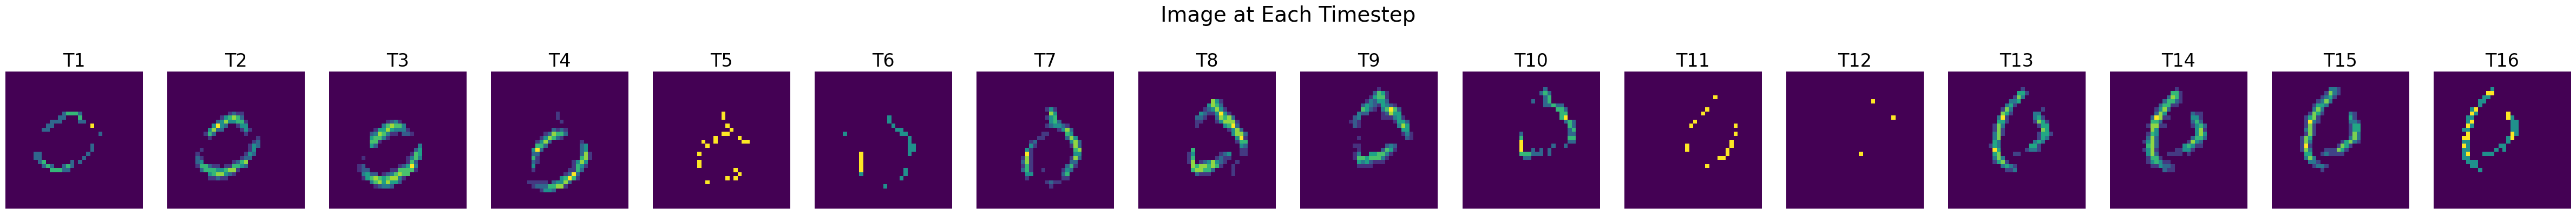

------Reconstructed Output-----


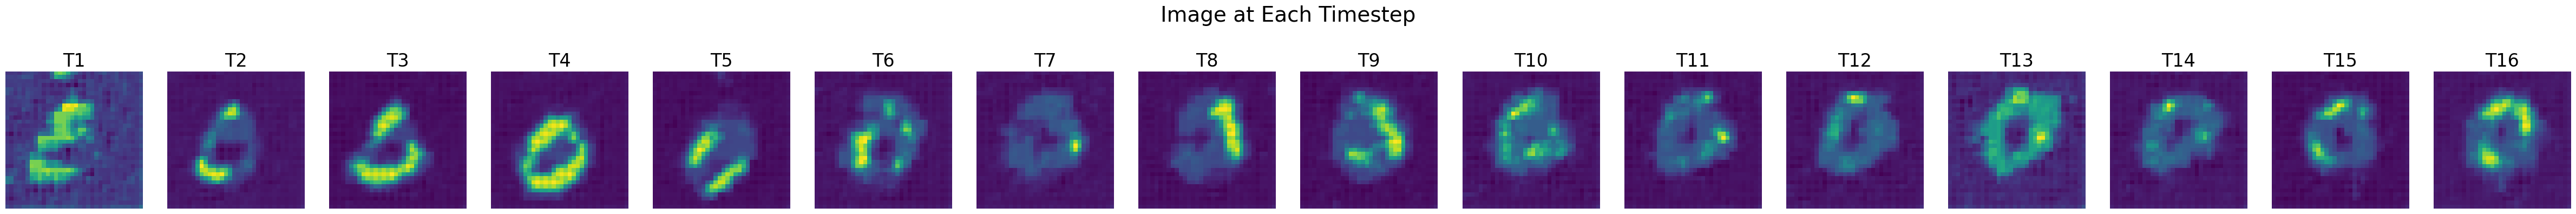

------------------------------------Label 1--------------------------------------------
------Original Events------


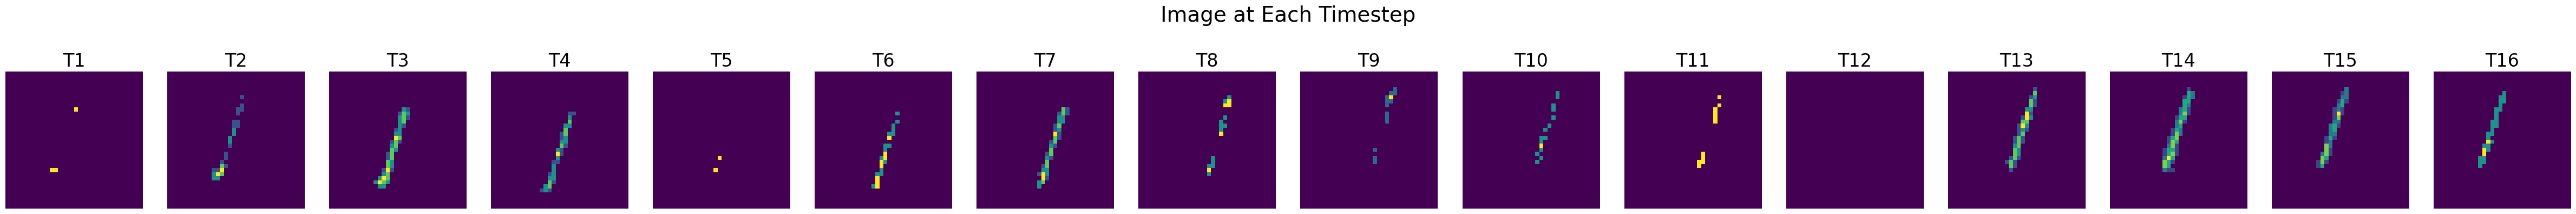

------Reconstructed Output-----


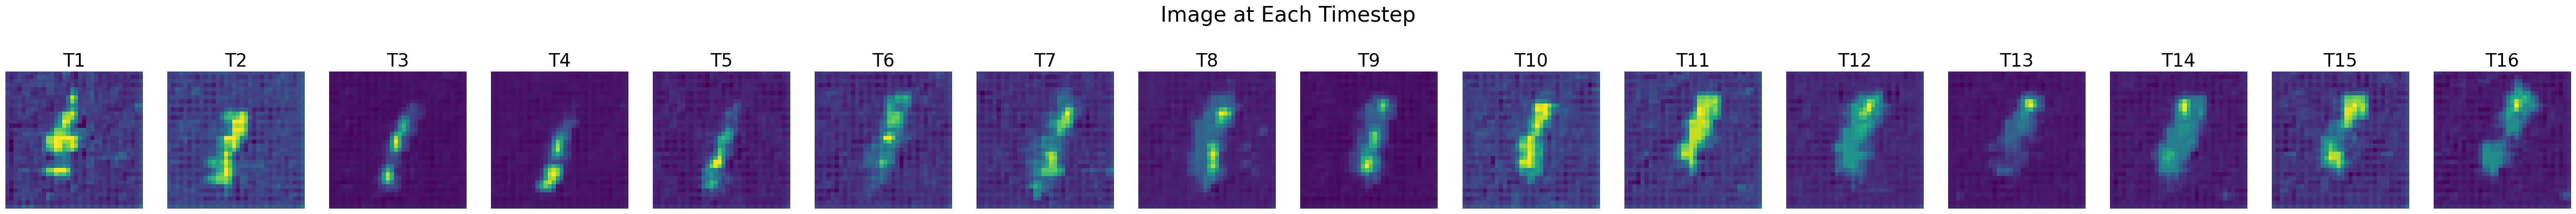

------------------------------------Label 2--------------------------------------------
------Original Events------


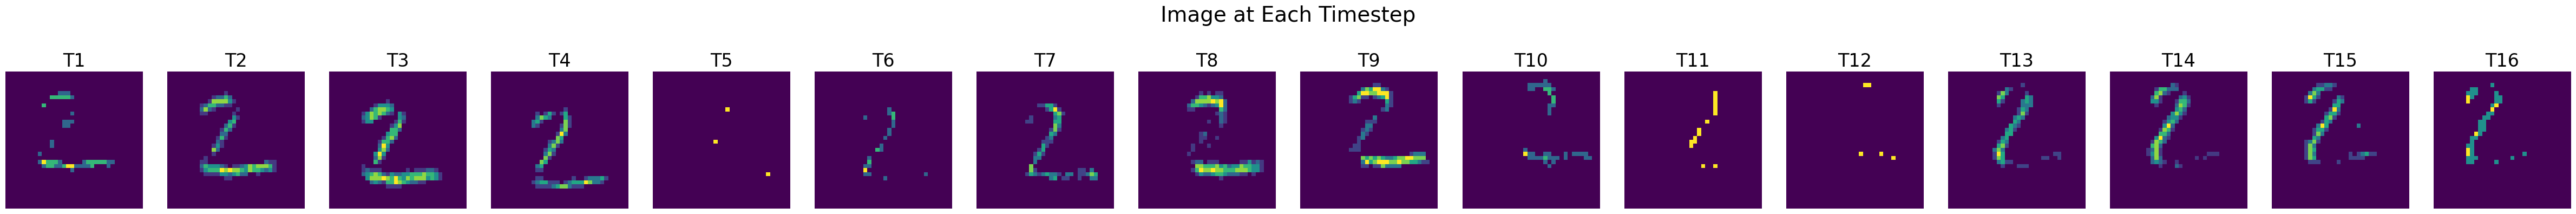

------Reconstructed Output-----


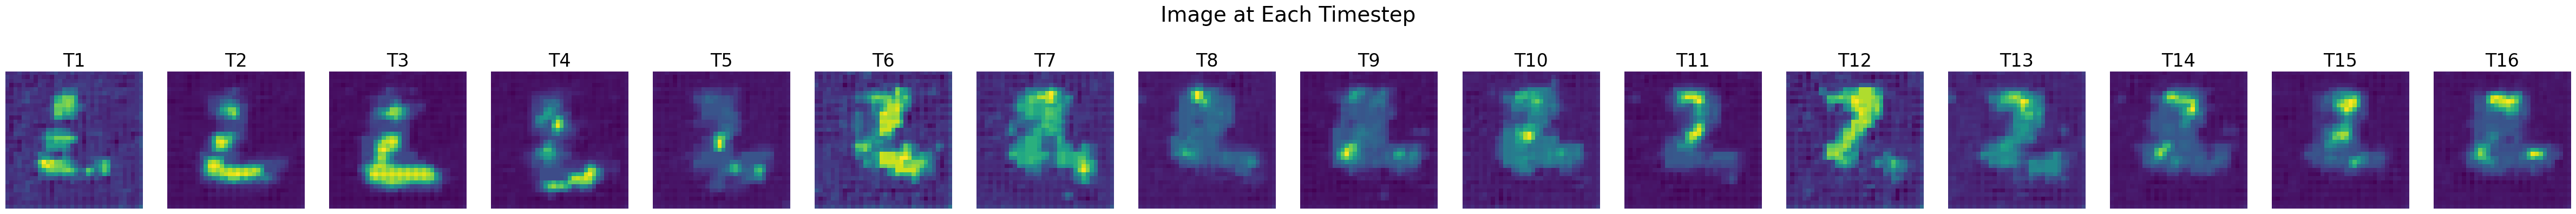

------------------------------------Label 3--------------------------------------------
------Original Events------


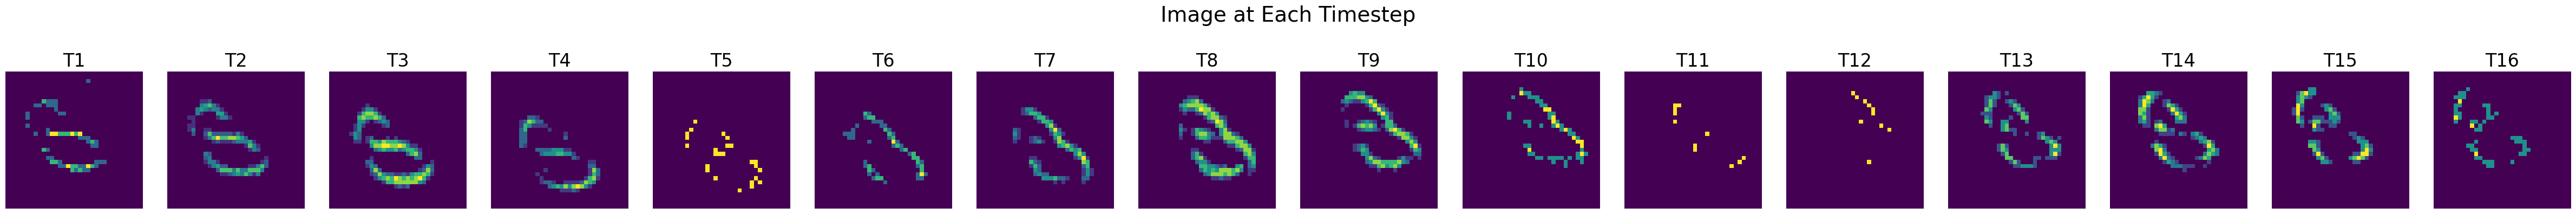

------Reconstructed Output-----


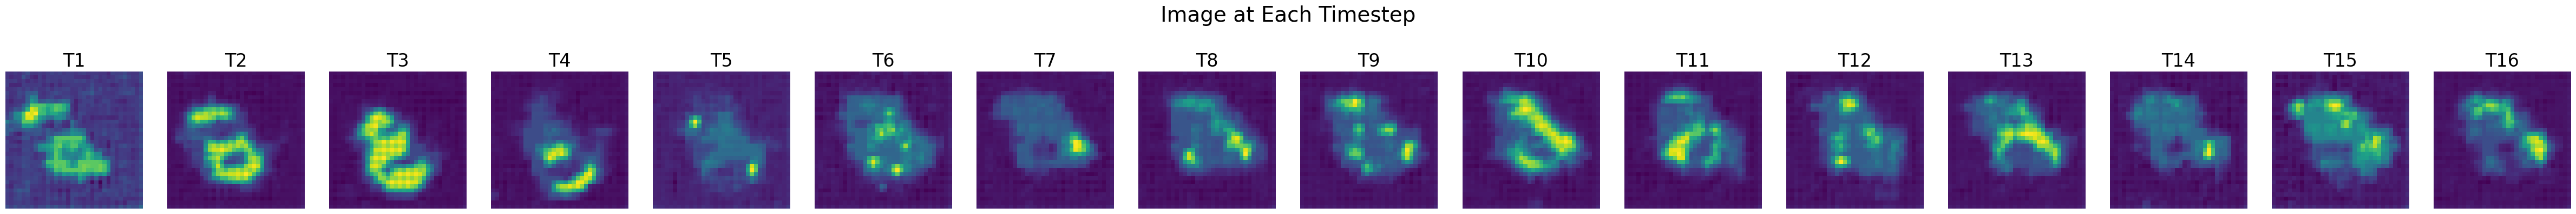

------------------------------------Label 4--------------------------------------------
------Original Events------


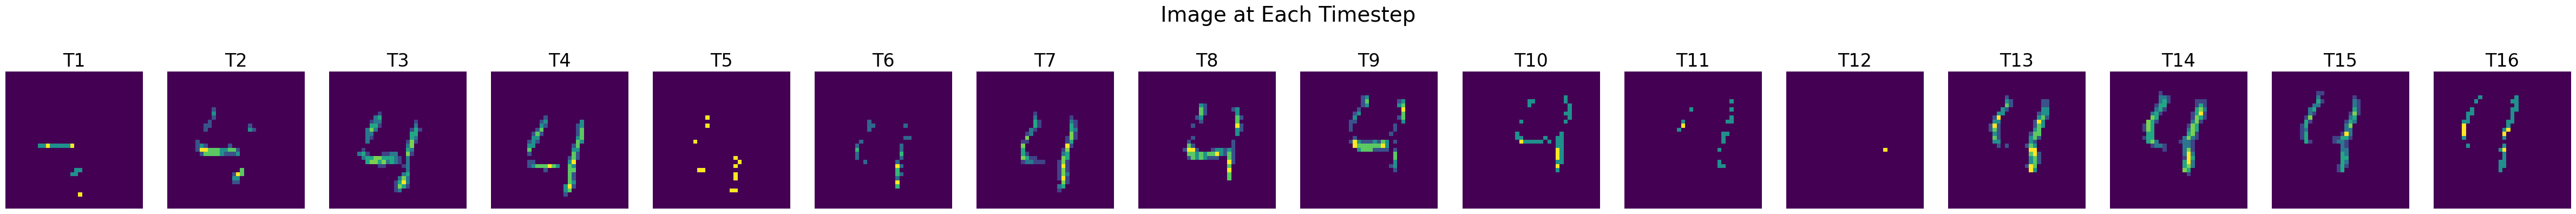

------Reconstructed Output-----


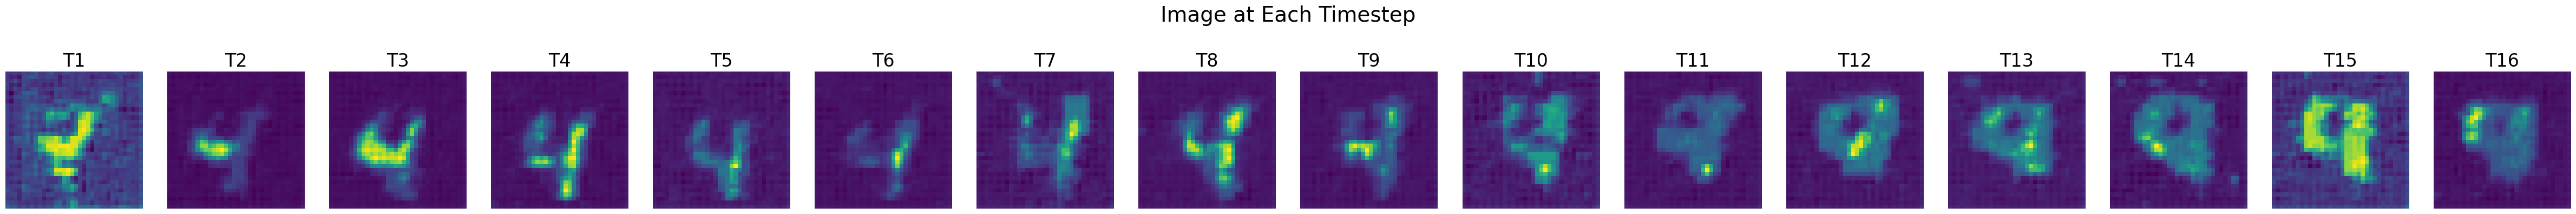

------------------------------------Label 5--------------------------------------------
------Original Events------


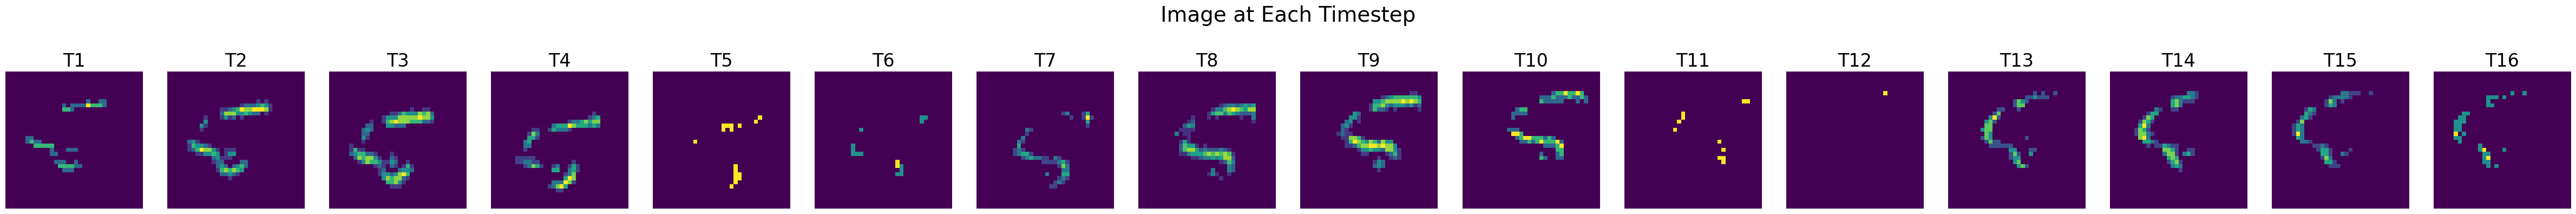

------Reconstructed Output-----


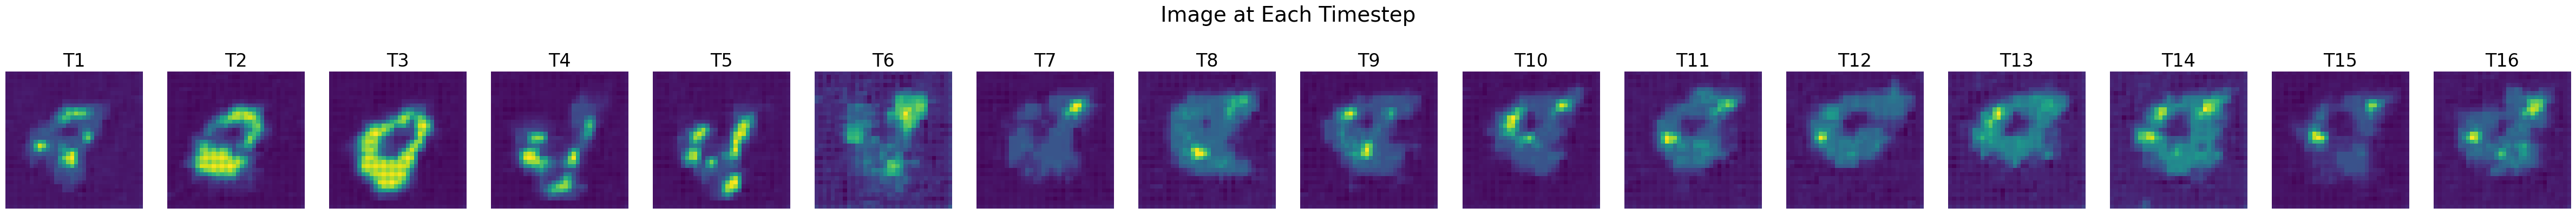

------------------------------------Label 6--------------------------------------------
------Original Events------


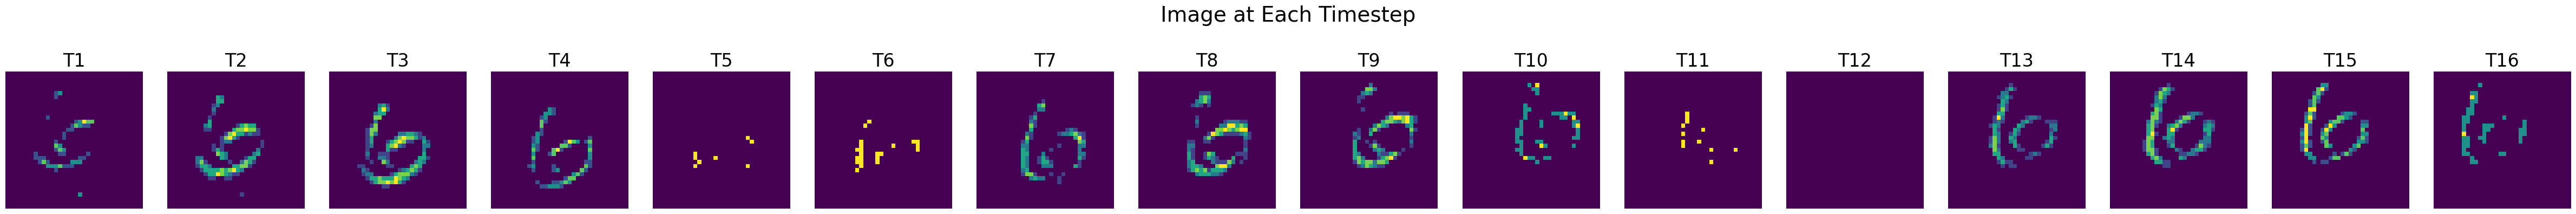

------Reconstructed Output-----


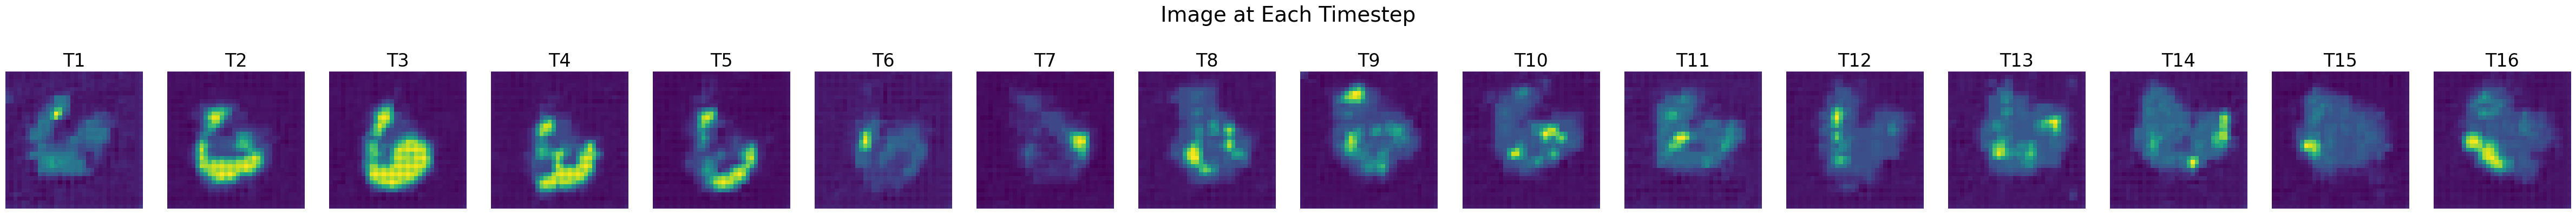

------------------------------------Label 7--------------------------------------------
------Original Events------


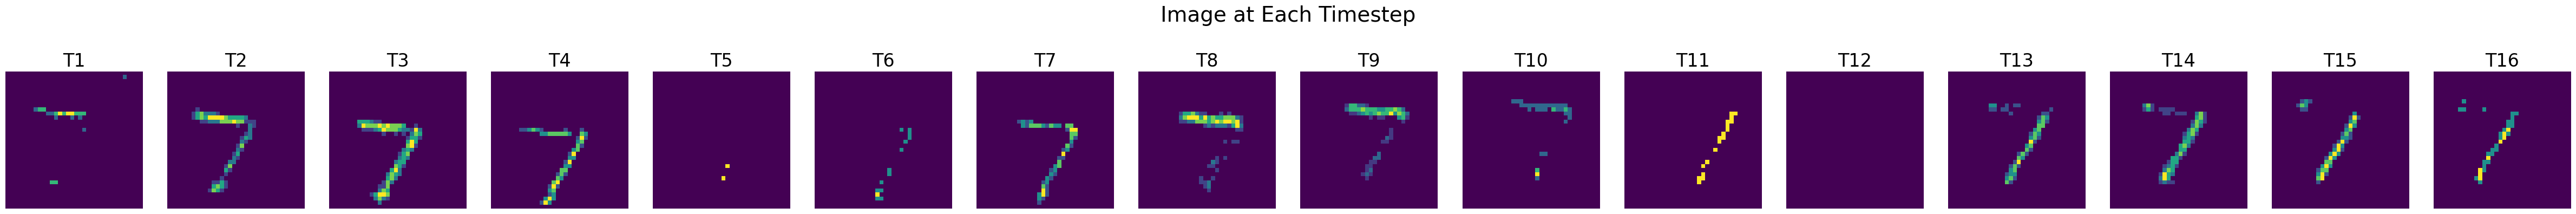

------Reconstructed Output-----


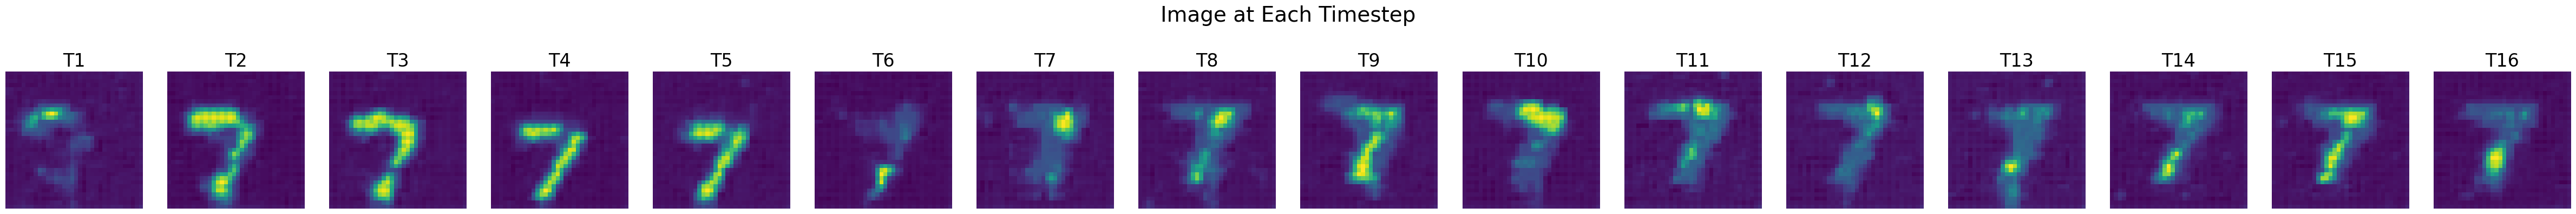

------------------------------------Label 8--------------------------------------------
------Original Events------


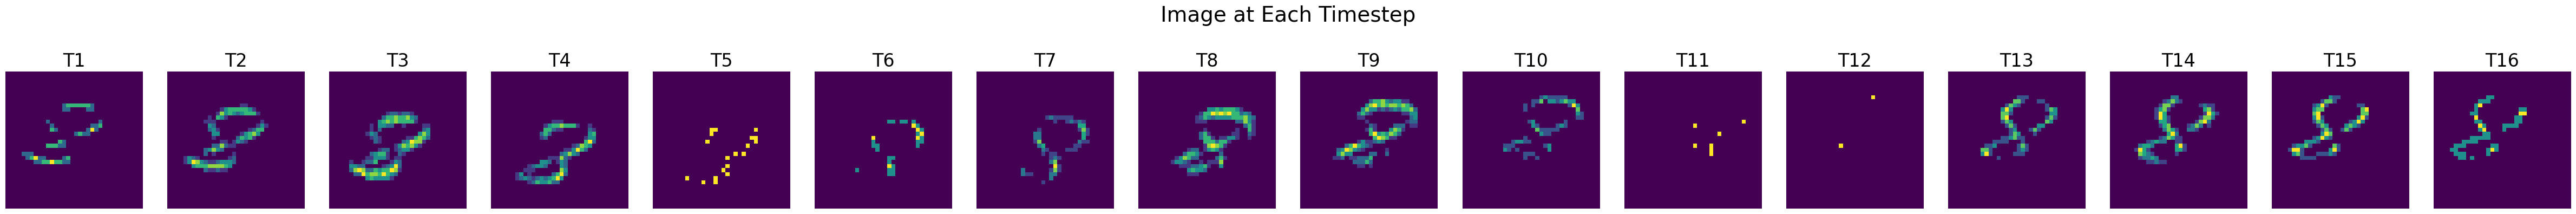

------Reconstructed Output-----


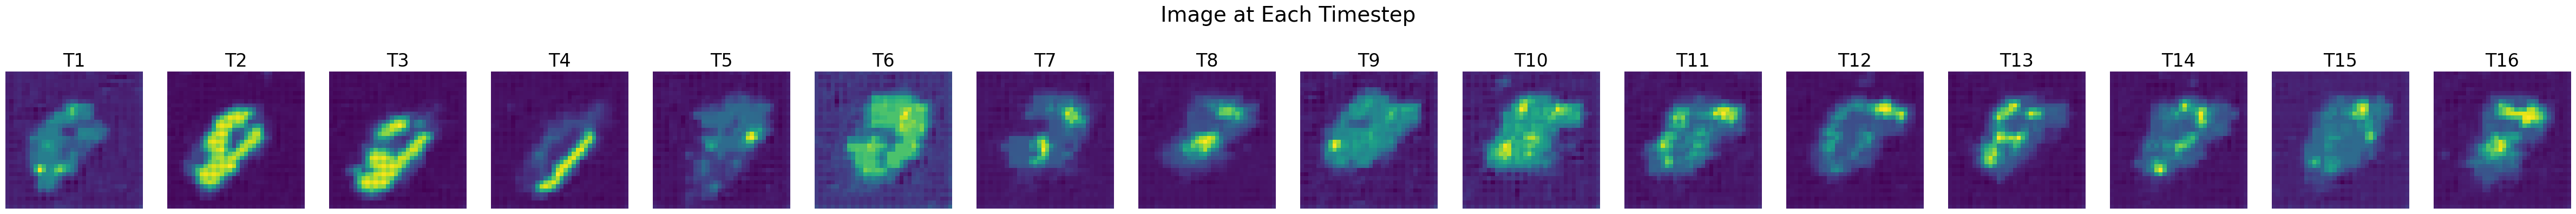

------------------------------------Label 9--------------------------------------------
------Original Events------


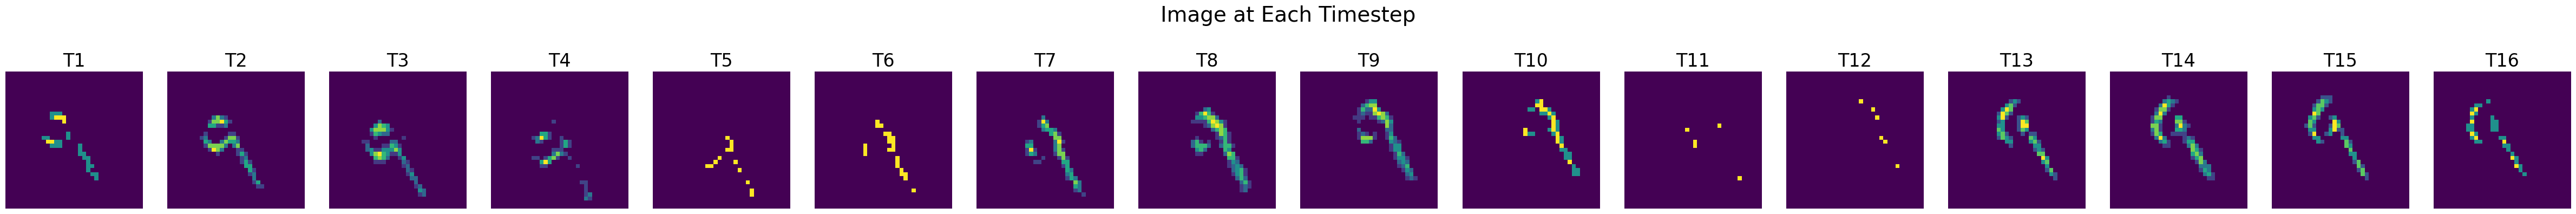

------Reconstructed Output-----


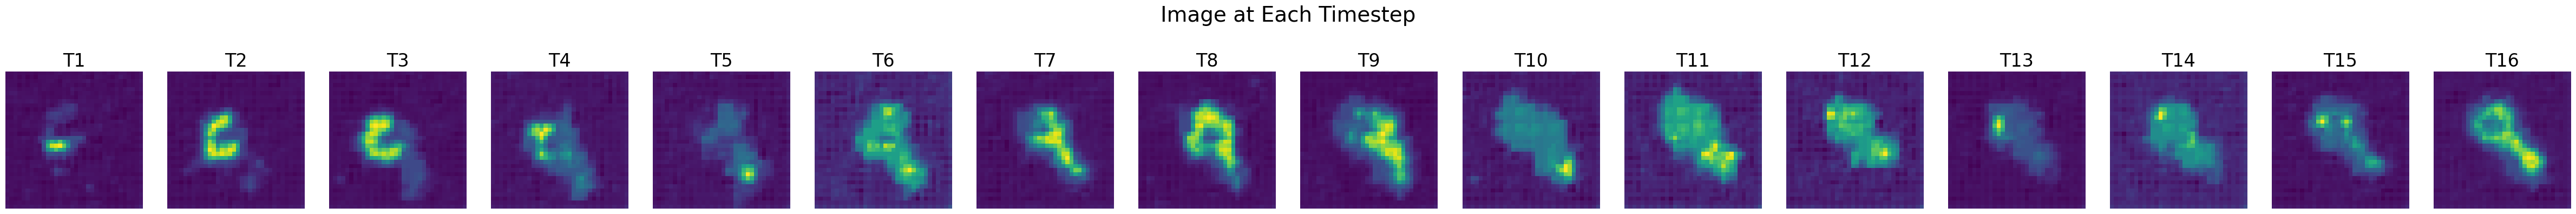

In [69]:
def visualize_digits(network, testloader):
    i = 0
    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, labels) in enumerate(testloader):
            if i == 10:
                break
            real_img = real_img.to('cuda:0', non_blocking=True)
            labels = labels.to('cuda:0', non_blocking=True)
            spike_input = real_img.unsqueeze(1)
            x_recon, r_q, r_p, sampled_z_q = network(spike_input,
                                                  scheduled=True)  # sampled_z (N, latent_dim, T)

            for j in range(len(spike_input)):
                if i == 10:
                    break
                if int(labels[j]) == i:
                    print('------------------------------------Label ' +str(int(labels[j]))+'--------------------------------------------')
                    print('------Original Events------')
                    plot_frames_without_polarity_permuted(spike_input[j][0])
                    print('------Reconstructed Output-----')
                    plot_frames_without_polarity_permuted(x_recon[j][0])
                    i = i + 1

visualize_digits(net, testloader)


<h3>Visualizing Animation</h3>

In [78]:
network = net.eval()
with torch.no_grad():
    real_img, labels = next(iter(trainloader))
    real_img = real_img.to('cuda:0', non_blocking=True)
    labels = labels.to('cuda:0', non_blocking=True)
    spike_input = real_img.unsqueeze(1)
    x_recon, r_q, r_p, sampled_z_q = network(spike_input, scheduled=True)

<h4>Animation 1</h4>

Input

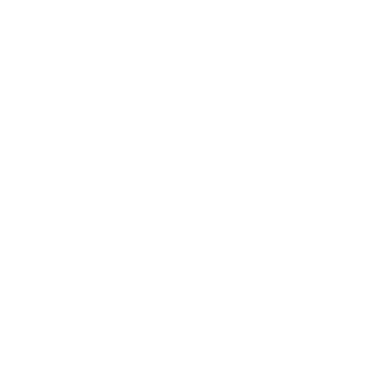

In [107]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[0][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

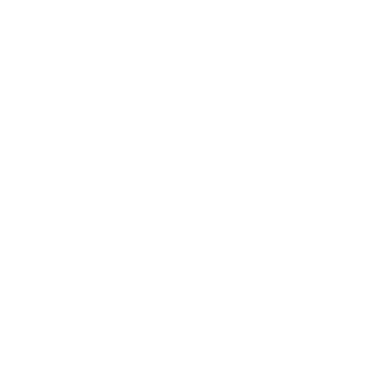

In [108]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[0][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

In [109]:
fig, ax = plt.subplots()
anim = splt.animator(sampled_z_q[0].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 2</h4>
Original

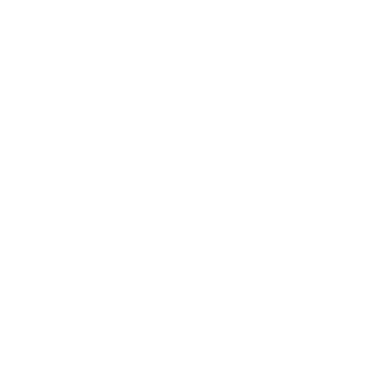

In [110]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[11][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

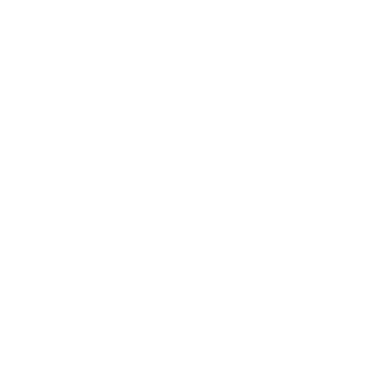

In [111]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[11][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

In [112]:
fig, ax = plt.subplots()
anim = splt.animator(sampled_z_q[11].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 3</h4>
Original

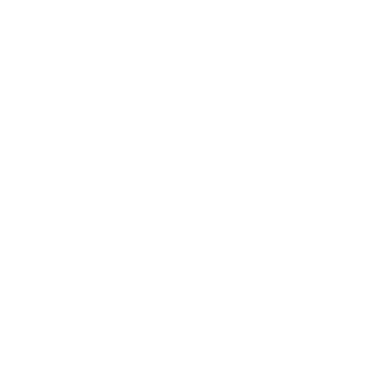

In [113]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[22][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

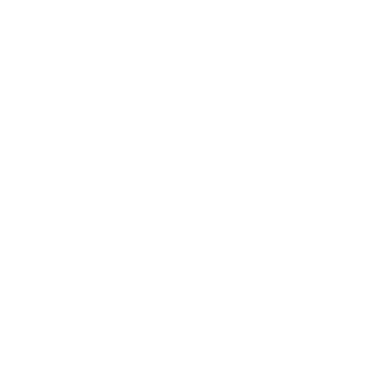

In [114]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[22][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

In [115]:
fig, ax = plt.subplots()
anim = splt.animator(sampled_z_q[22].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 4</h4>
Original

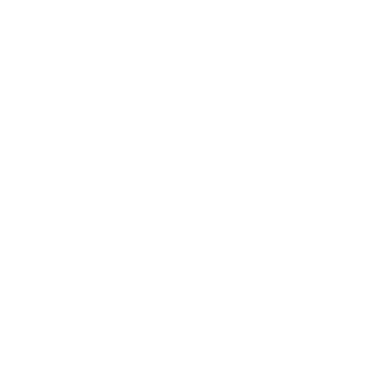

In [116]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[1][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

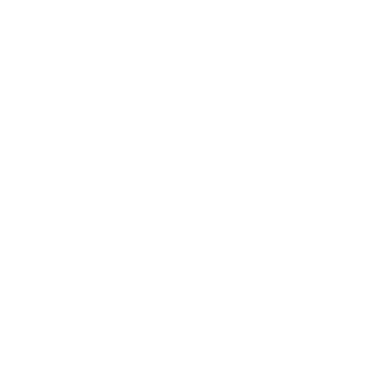

In [117]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[1][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

In [118]:
fig, ax = plt.subplots()
anim = splt.animator(sampled_z_q[1].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<h4>Animation 5</h4>
Original

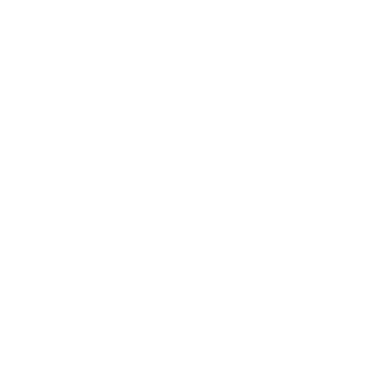

In [119]:
fig, ax = plt.subplots()
anim = splt.animator(spike_input[4][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Reconstruction

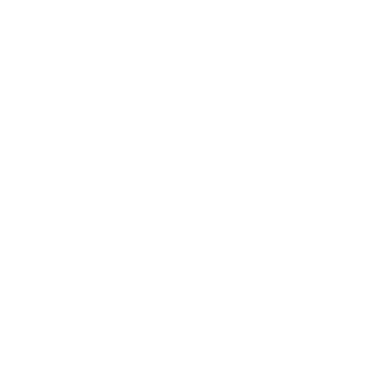

In [120]:
fig, ax = plt.subplots()
anim = splt.animator(x_recon[4][0].permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

Latent

In [121]:
fig, ax = plt.subplots()
anim = splt.animator(sampled_z_q[4].unsqueeze(0).permute(2, 0, 1), fig, ax)
HTML(anim.to_html5_video())

<H3> Save Model</H3>

In [131]:
torch.save(net.state_dict(), 'vae_nmnist_final_model.pt')

<h3>Classifier</h3>

In [135]:
base_model = VAE()
base_model = base_model.to('cuda:0')
base_model.load_state_dict(torch.load('vae_nmnist_final_model.pt', weights_only=True))


<All keys matched successfully>

<h4>Imports</h4>

In [136]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

<h4>Define Classifier</h4>

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEClassifier(nn.Module):
    def __init__(self, base_model: VAE, num_classes: int = 10, device='cuda:0', init_beta=0.9):
        super().__init__()

        # Use pretrained encoder and latent layer from ESVAE
        self.encoder = base_model.encoder
        self.before_latent_layer = base_model.before_latent_layer
        self.sample_layer = base_model.sample_layer
        self.device = device

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.before_latent_layer.parameters():
            param.requires_grad = False
        for param in self.sample_layer.parameters():
            param.requires_grad = False

        self.n_steps = base_model.n_steps  # usually 16
        self.latent_dim = base_model.latent_dim  # usually 64

        self.spike_fn = surrogate.fast_sigmoid()

        self.lif1 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc2 = nn.Linear(self.latent_dim, 128)
        self.lif2 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc3 = nn.Linear(128, num_classes)
        self.lif3 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

    def forward(self, x):
        x = self.encoder(x)  # shape: (N, C, H, W, T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N, C*H*W, T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        batch_size = sampled_z_q.size(0)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3  = self.lif2.init_leaky()

        spk3_record = []

        for t in range(self.n_steps):
            input_t = sampled_z_q[:, :, t]
            spk1, mem1 = self.lif1(input_t, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_record.append(spk3)

        spk3_record = torch.stack(spk3_record, dim=2)  # (B, num_classes, T)
        out = spk3_record.sum(dim=2)  # summed over time
        spk3_record = spk3_record.permute(2, 0, 1)
        return out, spk3_record


    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        if latent_x is not None:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None


<h4>Define Test and Train</h4>

In [141]:
import torch
import torch.nn as nn
from snntorch import functional as SF
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Helper to compute metrics
def compute_metrics(output_spikes, labels):
    # Sum over time: (B, C, T) -> (B, C)
    spike_sum = output_spikes.sum(dim=0)
    preds = spike_sum.argmax(dim=-1).cpu()
    labels = labels.cpu()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


# Training loop
def train_one_epoch_classifier(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_metrics = []
    for data, targets in dataloader:
        data = data.to(device)            # shape: (B, C, H, W, T) or (B, input_dim, T)
        targets = targets.to(device)
        spike_input = data.unsqueeze(1)
        optimizer.zero_grad()
        logits, spike_record = model(spike_input)   # (B, C, T)
        loss = criterion(spike_record, targets)
        loss.backward()
        optimizer.step()

        acc, f1, precision, recall = compute_metrics(spike_record, targets)
        all_metrics.append((loss.item(), acc, f1, precision, recall))

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item()
    }


# Evaluation loop
def test_classifier(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_metrics = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1)
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            acc, f1, precision, recall = compute_metrics(spike_record, targets)
            all_metrics.append((loss.item(), acc, f1, precision, recall))

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item()
    }


<h4>Instantiate Model and Train</h4>

In [142]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAEClassifier(base_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = SF.ce_rate_loss()
# Training
for epoch in range(5):
    train_metrics = train_one_epoch_classifier(model, trainloader, optimizer, criterion, device)
    test_metrics = test_classifier(model, testloader, criterion, device)

    print(f"Epoch {epoch+1}")
    print("Train:", train_metrics)
    print("Test :", test_metrics)


Epoch 1
Train: {'loss': 1.779188390604655, 'accuracy': 0.77605}
Test : {'loss': 1.6934870360003915, 'accuracy': 0.8493232484076433}
Epoch 2
Train: {'loss': 1.698567120552063, 'accuracy': 0.8352833333333334}
Test : {'loss': 1.6642452577117142, 'accuracy': 0.8695262738853503}
Epoch 3
Train: {'loss': 1.677363898976644, 'accuracy': 0.84405}
Test : {'loss': 1.6492043194497468, 'accuracy': 0.8680334394904459}
Epoch 4
Train: {'loss': 1.6664695612589517, 'accuracy': 0.8502833333333333}
Test : {'loss': 1.6410635178256188, 'accuracy': 0.8800756369426752}
Epoch 5
Train: {'loss': 1.6594829638799031, 'accuracy': 0.8534833333333334}
Test : {'loss': 1.6390820680909854, 'accuracy': 0.8710191082802548}


<h4>Display and Save Metrics</h4>

In [143]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def display_results(model, dataloader, criterion, device, loop='train'):
    model.eval()
    all_metrics = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1)
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            # Aggregate spikes over time
            spike_sum = spike_record.sum(dim=0)  # (B, C)
            preds = spike_sum.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_metrics.append(loss.item())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification Report
    print("\n📊 Classification Report ("+loop+" Set):")
    # Classification Report
    print("\n📊 Classification Report ("+loop+" Set):")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('NMNIST Test Dataset: Confusion Matrix')
    # Save the figure
    plt.savefig('confusion_matrix_'+loop+'_data_nmnist_full_run.png', dpi=300, bbox_inches='tight')
    plt.show()


    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    return {
        'loss': np.mean(all_metrics),
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


📊 Classification Report (train Set):

📊 Classification Report (train Set):
              precision    recall  f1-score   support

           0     0.9099    0.9615    0.9350      5923
           1     0.8585    0.9726    0.9120      6742
           2     0.9060    0.9023    0.9041      5958
           3     0.7940    0.8609    0.8261      6131
           4     0.8215    0.8956    0.8569      5842
           5     0.9231    0.7224    0.8105      5421
           6     0.8972    0.9544    0.9249      5918
           7     0.9085    0.8275    0.8661      6265
           8     0.8227    0.7477    0.7834      5851
           9     0.8197    0.7705    0.7944      5949

    accuracy                         0.8641     60000
   macro avg     0.8661    0.8615    0.8613     60000
weighted avg     0.8656    0.8641    0.8625     60000



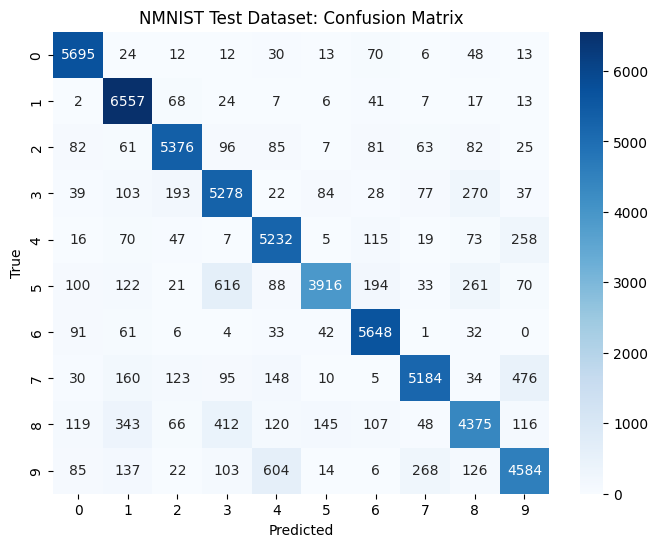

{'loss': 1.643646514892578,
 'accuracy': 0.8640833333333333,
 'f1': 0.8613451073068024,
 'precision': 0.8661154660212343,
 'recall': 0.8615328602139632}

In [144]:
display_results(model, trainloader, criterion, device, loop='train')


📊 Classification Report (test Set):

📊 Classification Report (test Set):
              precision    recall  f1-score   support

           0     0.9068    0.9633    0.9342       980
           1     0.9064    0.9815    0.9425      1135
           2     0.9215    0.8866    0.9037      1032
           3     0.7920    0.8822    0.8347      1010
           4     0.8481    0.9094    0.8776       982
           5     0.9177    0.7377    0.8179       892
           6     0.8993    0.9603    0.9288       958
           7     0.8966    0.8093    0.8507      1028
           8     0.8081    0.7823    0.7950       974
           9     0.8333    0.7830    0.8074      1009

    accuracy                         0.8719     10000
   macro avg     0.8730    0.8696    0.8692     10000
weighted avg     0.8731    0.8719    0.8706     10000



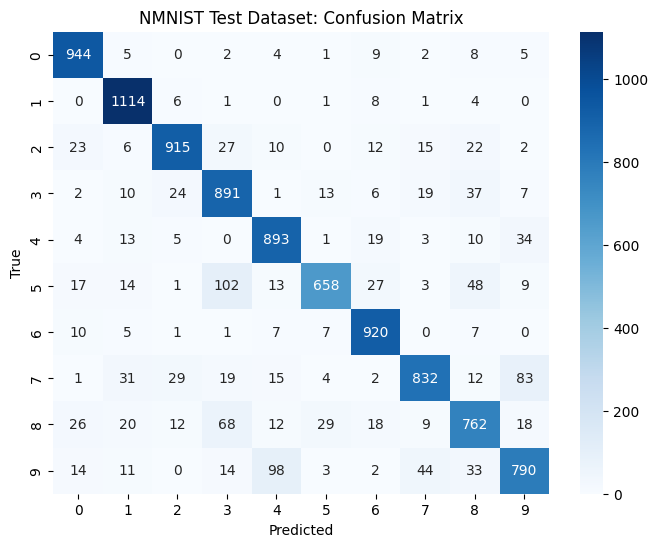

{'loss': 1.638288412124488,
 'accuracy': 0.8719,
 'f1': 0.8692456052338275,
 'precision': 0.8729724559923128,
 'recall': 0.8695572857428955}

In [145]:
display_results(model, testloader, criterion, device, loop='test')

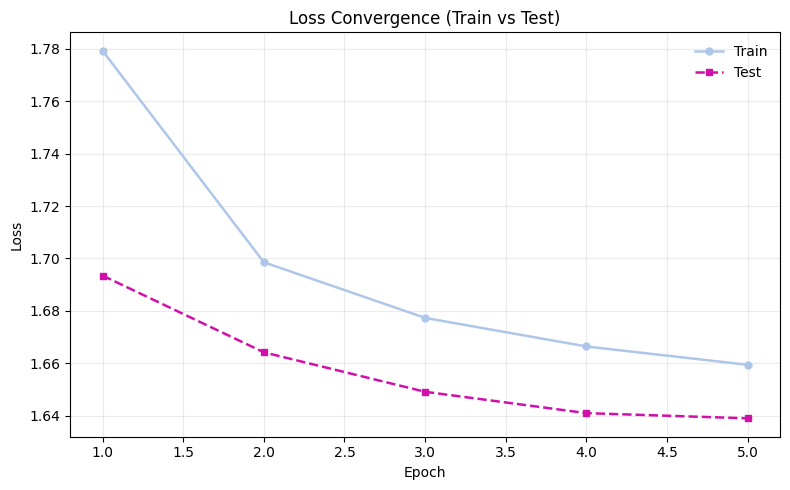

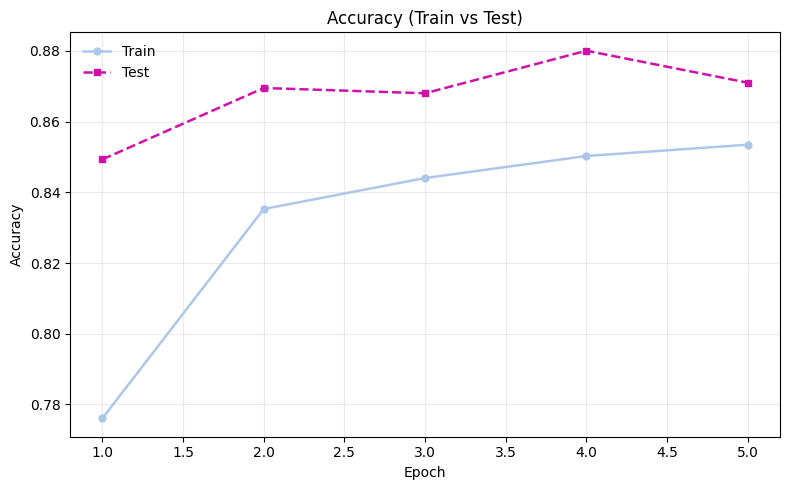

In [169]:
import os
import matplotlib.pyplot as plt

# ---- put your epoch logs here (from your printout) ----
metrics = [
    {"train": {"loss": 1.779188390604655, "accuracy": 0.77605},
     "test":  {"loss": 1.6934870360003915, "accuracy": 0.8493232484076433}},
    {"train": {"loss": 1.698567120552063, "accuracy": 0.8352833333333334},
     "test":  {"loss": 1.6642452577117142, "accuracy": 0.8695262738853503}},
    {"train": {"loss": 1.677363898976644, "accuracy": 0.84405},
     "test":  {"loss": 1.6492043194497468, "accuracy": 0.8680334394904459}},
    {"train": {"loss": 1.6664695612589517, "accuracy": 0.8502833333333333},
     "test":  {"loss": 1.6410635178256188, "accuracy": 0.8800756369426752}},
    {"train": {"loss": 1.6594829638799031, "accuracy": 0.8534833333333334},
     "test":  {"loss": 1.6390820680909854, "accuracy": 0.8710191082802548}},
]

# ---- extract series ----
epochs = list(range(1, len(metrics) + 1))
train_loss = [m["train"]["loss"] for m in metrics]
test_loss  = [m["test"]["loss"]  for m in metrics]
train_acc  = [m["train"]["accuracy"] for m in metrics]
test_acc   = [m["test"]["accuracy"]  for m in metrics]

# ---- plotting helpers ----
def plot_two(x, y1, y2, title, ylabel, fname=None):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, y1, marker="o", lw=1.8, ms=5, label="Train", color="#AEC7E8")
    ax.plot(x, y2, marker="s", lw=1.8, ms=5, linestyle="--", label="Test", color="#d110AA")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(frameon=False)
    fig.tight_layout()
    if fname:
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        fig.savefig(fname, bbox_inches="tight", dpi=160)
    plt.show()

# ---- make the plots (and optionally save) ----
out_dir = "vae_v6/checkpoint/nmnist/classification/plots"  # change or set to None if you don't want files
plot_two(epochs, train_loss, test_loss,
         title="Loss Convergence (Train vs Test)", ylabel="Loss",
         fname=os.path.join(out_dir, "loss_convergence.png") if out_dir else None)

plot_two(epochs, train_acc, test_acc,
         title="Accuracy (Train vs Test)", ylabel="Accuracy",
         fname=os.path.join(out_dir, "accuracy.png") if out_dir else None)


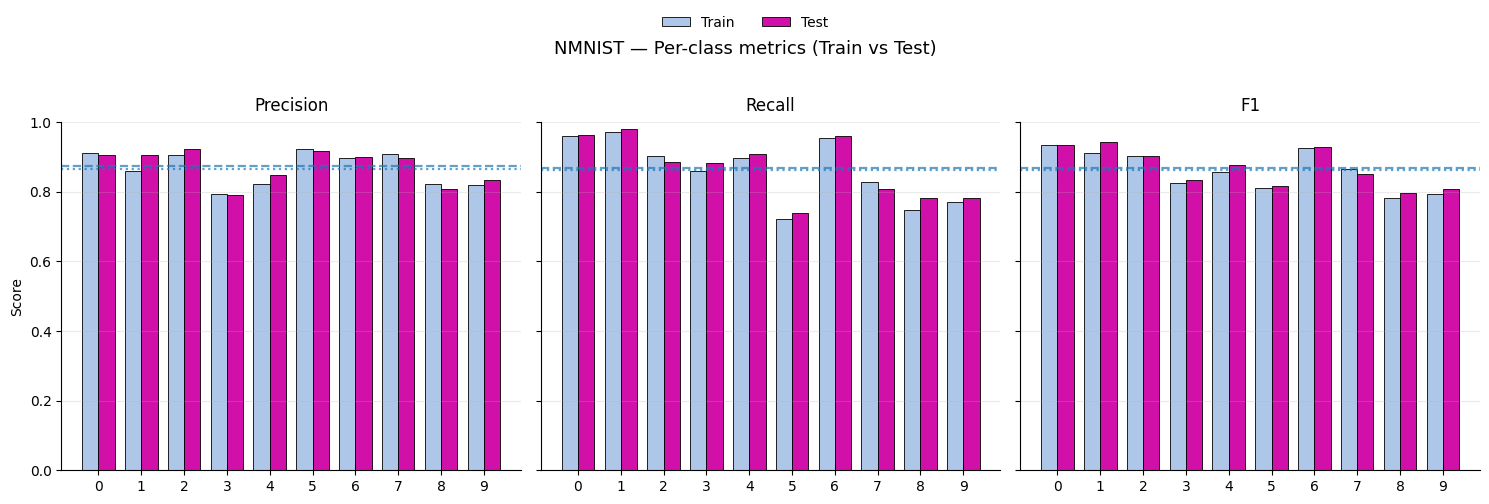

In [168]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===== paste your numbers =====
classes = [str(i) for i in range(10)]

train = {
    "precision": [0.9099, 0.8585, 0.9060, 0.7940, 0.8215, 0.9231, 0.8972, 0.9085, 0.8227, 0.8197],
    "recall":    [0.9615, 0.9726, 0.9023, 0.8609, 0.8956, 0.7224, 0.9544, 0.8275, 0.7477, 0.7705],
    "f1":        [0.9350, 0.9120, 0.9041, 0.8261, 0.8569, 0.8105, 0.9249, 0.8661, 0.7834, 0.7944],
    "macro":     {"precision": 0.8661, "recall": 0.8615, "f1": 0.8613},
}
test = {
    "precision": [0.9068, 0.9064, 0.9215, 0.7920, 0.8481, 0.9177, 0.8993, 0.8966, 0.8081, 0.8333],
    "recall":    [0.9633, 0.9815, 0.8866, 0.8822, 0.9094, 0.7377, 0.9603, 0.8093, 0.7823, 0.7830],
    "f1":        [0.9342, 0.9425, 0.9037, 0.8347, 0.8776, 0.8179, 0.9288, 0.8507, 0.7950, 0.8074],
    "macro":     {"precision": 0.8730, "recall": 0.8696, "f1": 0.8692},
}
# =================================

def plot_per_class_grid(train, test, classes, suptitle="Per-class metrics (Train vs Test)",
                        out_path=None, bar_width=0.38):
    metrics = ["precision", "recall", "f1"]
    x = np.arange(len(classes))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.6), sharey=True)
    for ax, metric in zip(axes, metrics):
        # Bars
        ax.bar(x - bar_width/2, train[metric], width=bar_width, label="Train", color="#AEC7E8",
               edgecolor="black", linewidth=0.6),
        ax.bar(x + bar_width/2, test[metric],  width=bar_width, label="Test", color="#d110AA", 
               edgecolor="black", linewidth=0.6)

        # Macro-average guide lines
        ax.axhline(train["macro"][metric], linestyle=":", linewidth=1.6, alpha=0.7)
        ax.axhline(test["macro"][metric],  linestyle="--", linewidth=1.6, alpha=0.7)

        # Cosmetics
        ax.set_title(metric.capitalize(), pad=8)
        ax.set_xticks(x, classes)
        ax.set_ylim(0, 1.0)
        ax.grid(True, axis="y", alpha=0.25)
        for spine in ("top", "right"):
            ax.spines[spine].set_visible(False)

    axes[0].set_ylabel("Score")
    fig.suptitle(suptitle, y=1.02, fontsize=13)

    # Single legend above subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncols=2, frameon=False, bbox_to_anchor=(0.5, 1.10))

    fig.tight_layout()
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.show()

# Use it
plot_per_class_grid(train, test, classes, suptitle="NMNIST — Per-class metrics (Train vs Test)",
                    out_path="vae_v6/checkpoint/nmnist/classification/plots/mnist_per_class_metrics.png")
